# Schmidt et al., 2023: Plots and numbers of paper

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cosima_cookbook as cc
from dask.distributed import Client
import warnings
warnings.simplefilter('ignore')
import sys
sys.path.append("/home/142/cs6673/work/iav_AABW/Python_scripts_final/") 
from iav_AABW_functions import (
    shelf_mask_isobath, mask_from_polygon,
    yearly_mean, yearly_sum,
    select_bottom_values, correlation_3D)
from numpy.fft import fftfreq
from scipy.fftpack import fft
from datetime import timedelta

## plotting
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cmocean
import cartopy.crs as ccrs
import matplotlib.path as mpath
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.ticker as mticker
import string
import calendar

In [2]:
plt.rcParams['figure.dpi'] = 96
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["lines.linewidth"] = 1.5
plt.rcParams["lines.markersize"] = 3
plt.rcParams['hatch.color'] = 'k'
plt.rcParams["savefig.facecolor"] = 'white'

## Parameters

In [3]:
year_all = range(1958, 2019)
expt = '01deg_jra55v140_iaf_cycle3'
frequency = '1 monthly'

path_output = '/g/data/e14/cs6673/iav_AABW/data_iav_AABW_final/'
path_Plots = '/g/data/e14/cs6673/iav_AABW/Plots_paper_final/'
savefigures = True

In [4]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 48,Total memory: 180.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35205,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 180.00 GiB
Comm: tcp://127.0.0.1:45765,Total threads: 6
Dashboard: /proxy/46571/status,Memory: 22.50 GiB
Nanny: tcp://127.0.0.1:45143,


In [5]:
DSW_region = {
    'name': ['Weddell', 'Prydz', 'Adelie', 'Ross'],
    'name_long': ['Weddell Sea', 'Prydz Bay', 'Adélie Coast', 'Ross Sea'],
    'lon': [[-60, -35, -48, -62, -60],
            [48, 73, 74, 48, 48],
            [128-360, 152-360, 152-360, 128-360, 128-360],
            [185-360, 160-360, 164-360, 172-360, 185-360]],
    'lat': [[-71, -75, -78, -75, -71],
            [-65, -66.5, -69, -68, -65],
            [-64.5, -66, -69, -67.5, -64.5],
            [-78, -78, -73, -71.5, -78]],
    'sig0_bins': [27.92, 27.81, 27.81, 28],
    'ind_iso_min': [3647, 5151, 581, 1141],
    'ind_iso_max': [4307, 134, 960, 1830],
    'sector': [[-65, 0, -78.5,  -62],
               [45, 80, -70, -60],
               [125-360, 165-360, -70, -60],
               [150-360, 220-360, -79, -65]],
    'mask_taux_lon': [[-58.5, -51, -36, -20, -20, -38, -58.5],
                      [35, 35, 80, 80, -280, -280, -230, -230],
                      [-225, -225, -210, -197, -197, -225],
                      [-171, -171, -140, -80, -80, -172]],
    'mask_taux_lat': [[-76.5, -72, -67.5, -69, -74, -78.8, -76.5],
                      [-65, -58, -58, -65, -65, -58, -58, -65],
                      [-67, -65, -65, -67.5, -71.8, -67],
                      [-79, -75, -67 , -67, -76, -79]]}

## Load data

In [6]:
session = cc.database.create_session()
ht = cc.querying.getvar(expt, 'ht', session, n=1) 
ht = ht.sel(yt_ocean=slice(-90, -40))
land_mask = (ht*0).fillna(1)
xt_ocean = cc.querying.getvar(
    expt, 'xt_ocean', session, frequency='static', n=1)
yt_ocean = cc.querying.getvar(
    expt, 'yt_ocean', session, frequency='static', n=1).sel(
    yt_ocean=slice(-90, -60))

In [7]:
for a, area_text in enumerate(DSW_region['name']):
    if a == 0:
        mask_DSW = mask_from_polygon(
            DSW_region['lon'][a], DSW_region['lat'][a],
            xt_ocean, yt_ocean).expand_dims(area=['Weddell'])
    else:
        mask_DSW = xr.concat((mask_DSW, mask_from_polygon(
            DSW_region['lon'][a], DSW_region['lat'][a],
            xt_ocean, yt_ocean).expand_dims(area=[area_text])), dim='area')
    mask_DSW, shelf_mask = shelf_mask_isobath(mask_DSW, output_mask=True)
mask_DSW = mask_DSW.where(mask_DSW == True)
mask_DSW = mask_DSW.where(land_mask == 0)
mask_DSW = mask_DSW .where(mask_DSW == 1, 0)

In [8]:
area_t = cc.querying.getvar(
    expt, 'area_t', session, frequency='static',  n=1,
    chunks={'yt_ocean': '100MB', 'xt_ocean': '100MB'})
area_t_DSW = (mask_DSW * area_t.sel(yt_ocean=slice(-90, -59)))

### Annual time series of SWMT, AABW export, salinity, winds, ice, etc

In [9]:
ds_timeseries = xr.open_dataset(
    path_output + 'Timeseries_yearly_of_AABW_export_SWMT_salinity_taux_ice_' +
    expt + '_' + str(year_all[0]) + '-' + str(year_all[-2]) + '.nc')
SWMT = ds_timeseries.SWMT
AABW_export = ds_timeseries.AABW_export
salt_DSW = ds_timeseries.salt
taux = ds_timeseries.taux
taux_Prydz = ds_timeseries.taux_Prydz
ice_transp = ds_timeseries.ice_transport
salt_adv = ds_timeseries.salt_advection
area_open_water = ds_timeseries.area_open_water

### SWMT

In [10]:
ds_SWMT_fig1 = xr.open_dataset(
    path_output + 'SWMT_for_sig0_in_AABW_formation_region_' + expt +
    '_' + frequency[0:3:2] + '_yearly_mean_' + str(year_all[0]) +
    '-' + str(year_all[-1]) + '.nc')
SWMT_fig1 = (ds_SWMT_fig1.binned_heat_transformation +
             ds_SWMT_fig1.binned_salt_transformation).mean('time')

# merge SWMT for density classes of each region into one field for plotting
SWMT_fig1_merged = SWMT_fig1[1, :, :].where(
    (SWMT_fig1.xt_ocean < 0) & (SWMT_fig1.xt_ocean > -90),
    SWMT_fig1[2, :, :])
SWMT_fig1_merged = SWMT_fig1_merged.where(
    (SWMT_fig1.xt_ocean < 0) & (SWMT_fig1.xt_ocean > -207),
    SWMT_fig1[0, :, :])
SWMT_fig1_merged = shelf_mask_isobath(SWMT_fig1_merged)
SWMT_fig1_merged = SWMT_fig1_merged.where(SWMT_fig1_merged != 0)

In [11]:
ds_SWMT_all_densities = xr.open_dataset(
    path_output + 'SWMT_in_AABW_formation_region_for_sig0_27-2_28-1_' + 
    expt + '_' + frequency[0:3:2] + '_' + str(year_all[0]) + '-' +
    str(year_all[-1]) + '.nc')
ds_SWMT_all_densities ['isopycnal_bins'] = ds_SWMT_all_densities.isopycnal_bins - .5*(
    ds_SWMT_all_densities.isopycnal_bins[1]-ds_SWMT_all_densities.isopycnal_bins[0])
# upper boundary of sig0 bin
SWMT_all_densities = yearly_mean(ds_SWMT_all_densities)
SWMT_all_densities = (SWMT_all_densities.binned_heat_transformation_in_AABW_region +
                      SWMT_all_densities.binned_salt_transformation_in_AABW_region)
# monthly resolution for seasonal cycle
SWMT_m = (ds_SWMT_all_densities.binned_heat_transformation_in_AABW_region +
          ds_SWMT_all_densities.binned_salt_transformation_in_AABW_region)
SWMT_m = SWMT_m.sel(isopycnal_bins=xr.DataArray(DSW_region['sig0_bins'], dims='AREA'),
                area=xr.DataArray(DSW_region['name'], dims='AREA'),
                method='nearest').rename({'AREA': 'area'}).transpose()

In [12]:
%%time
ds_SWMT_W = xr.open_dataset(
    path_output + 'SWMT_in_Weddell_for_sig0_27-6_28-1_' + expt + '_' +
    frequency[0:3:2] + '_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')
ds_SWMT_W['isopycnal_bins'] = ds_SWMT_W.isopycnal_bins - .5*(
    ds_SWMT_W.isopycnal_bins[1]-ds_SWMT_W.isopycnal_bins[0])
# upper boundary of sig0 bin
SWMT_W = (ds_SWMT_W.binned_heat_transformation +
          ds_SWMT_W.binned_salt_transformation).compute()

CPU times: user 2min 39s, sys: 46.7 s, total: 3min 26s
Wall time: 3min 16s


In [13]:
%%time
ds_SWMT_P = xr.open_dataset(
    path_output + 'SWMT_in_Prydz_for_sig0_27-6_28-1_' + expt + '_' +
    frequency[0:3:2] + '_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')
ds_SWMT_P['isopycnal_bins'] = ds_SWMT_P.isopycnal_bins - .5*(
    ds_SWMT_P.isopycnal_bins[1]-ds_SWMT_P.isopycnal_bins[0])
# upper boundary of sig0 bin
SWMT_P = (ds_SWMT_P.binned_heat_transformation +
          ds_SWMT_P.binned_salt_transformation).compute()

CPU times: user 1min 21s, sys: 23.5 s, total: 1min 45s
Wall time: 1min 39s


In [14]:
%%time
ds_SWMT_A = xr.open_dataset(
    path_output + 'SWMT_in_Adelie_for_sig0_27-6_28-1_' + expt + '_' +
    frequency[0:3:2] + '_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')
ds_SWMT_A['isopycnal_bins'] = ds_SWMT_A.isopycnal_bins - .5*(
    ds_SWMT_A.isopycnal_bins[1]-ds_SWMT_A.isopycnal_bins[0])
# upper boundary of sig0 bin
SWMT_A = (ds_SWMT_A.binned_heat_transformation +
          ds_SWMT_A.binned_salt_transformation).compute()

CPU times: user 1min 22s, sys: 24.4 s, total: 1min 46s
Wall time: 1min 40s


In [15]:
%%time
ds_SWMT_R = xr.open_dataset(
    path_output + 'SWMT_in_Ross_for_sig0_27-6_28-1_' + expt + '_' +
    frequency[0:3:2] + '_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')
ds_SWMT_R['isopycnal_bins'] = ds_SWMT_R.isopycnal_bins - .5*(
    ds_SWMT_R.isopycnal_bins[1]-ds_SWMT_R.isopycnal_bins[0])
# upper boundary of sig0 bin
SWMT_R = (ds_SWMT_R.binned_heat_transformation +
          ds_SWMT_R.binned_salt_transformation).compute()

CPU times: user 2min 19s, sys: 42.5 s, total: 3min 1s
Wall time: 2min 52s


### AABW tracer at 1000-m isobath

In [16]:
filename_tracer = (
    'Passive_tracer_AABW_at_bottom_along_1000m_isobath_' +
    expt + '_' + frequency[0:3:2] + '_mean_' +
    str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')
ds_tracer = xr.open_dataset(path_output + filename_tracer)
tracer_1000m = ds_tracer.passive_tracer_concentration.assign_coords(
    {'lon': ds_tracer.lon, 'lat': ds_tracer.lat})

In [17]:
AABW_export_m = xr.open_dataarray(
    path_output + 'AABW_export_across_1000m_isobath_' + expt +
    '_' + frequency[0:3:2] + '_' + str(year_all[0]) + '-' +
    str(year_all[-1]) + '.nc')

### AABW tracer

In [18]:
%%time
for a, area_text in enumerate(DSW_region['name']):
    print(a)
    tracer = cc.querying.getvar(
        expt, 'passive_' + area_text.lower(), session, frequency='1 daily',
        start_time='1962-01-01', end_time='1962-01-02',
        chunks={'yt_ocean': '100MB', 'xt_ocean': '100MB'})
    tracer = tracer.sel(yt_ocean=slice(-90, -59), time='1962-01-01').squeeze()
    tracer = select_bottom_values(tracer, expt, session)
    tracer = tracer.compute()

    if a == 0:
        tracer_all = tracer.expand_dims(area=[area_text])
    else:
        tracer_all = xr.concat((tracer_all, tracer.expand_dims(
            area=[area_text])), dim='area')
tracer_all.name = 'passive_tracer_concentration'
tracer_all.attrs = {'units': '1', 
    'name_long': 'passive tracer concentration from each AABW formation ' +
    'region in bottom most grid cell along 1000-m isobath'}

0


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/array/reductions.py:649: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


1
2
3


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.01/lib/python3.9/site-packages/dask/array/reductions.py:649: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


CPU times: user 11 s, sys: 1.04 s, total: 12.1 s
Wall time: 27.7 s


### Salinity in AABW formation region

In [19]:
# data for Hovmoeller
salt_DSW_mean = xr.open_dataarray(
    path_output + 'salt_absolute_spatial_mean_in_each_AABW_' +
    'formation_region_' + expt + '_' + frequency[0:3:2] + '_' +
    str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')
salt_DSW_mean = salt_DSW_mean[:, :-12, :]  # only 1958-2017

### Correlation of zonal wind with salinity in AABW formation

In [20]:
ds_taux_cor = xr.open_dataset(
    path_output + 'Correlation_zonal_wind_and_salinity_in_' +
    'AABW_formation_region_' + expt + '_' + frequency[0:3:2] +
    '_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')
taux_cor = ds_taux_cor.correlation
taux_pval = ds_taux_cor.p_value

### Ice groth in SWMT area and DSW formation region

In [21]:
ice_growth_swmt = xr.open_dataarray(
    path_output + 'Ice_growth_in_SWMT_area_' + expt + '_' + frequency[0:3:2] +
    '_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')

In [22]:
ice_growth_DSW = xr.open_dataarray(
    path_output + 'Ice_growth_in_DSW_formation_region_' + expt + '_' +
    frequency[0:3:2] + '_' + str(year_all[0]) + '-' + str(year_all[-1]) + '.nc')

### Bathymetry for schematic (Fig. 9)

In [23]:
# cut out bathymetry in the Weddell Sea and ...
latN_W = -65
latS_W = -79
lonW_W = -68
lonE_W = -30

lat_slice_W = slice(latS_W,latN_W)
lon_slice_W = slice(lonW_W,lonE_W)
ht_W = ht.sel(yt_ocean=lat_slice_W).sel(xt_ocean=lon_slice_W).compute()

# ... in the Ross Sea
latN_R = -61
latS_R = -76
lonW_R = 163.3
lonE_R = 180

lat_slice_R = slice(latS_R,latN_R)
lon_slice_R = slice(lonW_R-360,lonE_R-360)
ht_R = ht.sel(yt_ocean=lat_slice_R).sel(xt_ocean=lon_slice_R).compute()

# merge and smooth bathymethry

ht_new = ht_W.copy()
# Ross Sea bathymetry to replace Antarctic Peninsula
ht_new[-150:, :167] = ht_R.sel(yt_ocean=slice(-72.5, None)).isel(
    yt_ocean=slice(None, 150)).values
# smooth out boundary region between Weddell and Ross bathymetry
ht_new[180:, 150:167] = np.linspace(
    ht_new[180:, 150], ht_new[180:, 167], 17).transpose()

# remove seamounts in the Ross Sea
ht_new[270:, :67] = ht_new[270:, :67].where(ht_new[270:, :67] >= 2600, 2600)
ht_new[270:, 67:130] = ht_new[270:, 67:130].where(ht_new[270:, 67:130] >= 3000, 3000)
ht_new[267:270, :30] = np.tile([2450, 2500, 2570], (30, 1)).transpose()

ht_new = ht_new.fillna(0)

# interpolate onto grid with 4x higher resolution to avoid stripes
# at steep topography
lon_int = np.linspace(ht_new.xt_ocean[0], ht_new.xt_ocean[-1],
                      len(ht_new.xt_ocean) * 4)

lat_int = np.linspace(ht_new.yt_ocean[0], ht_new.yt_ocean[-1],
                      len(ht_new.yt_ocean) * 4)
ht_int = ht_new.interp(xt_ocean=lon_int, yt_ocean=lat_int).compute()

X, Y = np.meshgrid(lon_int, lat_int)

In [24]:
# data for topo on front east face:
temp = cc.querying.getvar(
    expt,'temp', session, frequency=frequency,
    start_time='2000-01-01', end_time='2000-01-31')
temp_front = temp.sel(yt_ocean=lat_slice_W).sel(
    xt_ocean=lonE_W,method='nearest').mean('time')
Yf,Zf = np.meshgrid(temp_front.yt_ocean, -temp_front.st_ocean)

# calculate topo on front face:
st_edges_ocean = cc.querying.getvar(
    expt, 'st_edges_ocean', session,
    start_time='2000-01-01', end_time='2000-01-31', n=1)
st_edges_array = st_edges_ocean.expand_dims(
    {'yt_ocean':ht_new.yt_ocean},axis=[1])

htE = ht_new.sel(xt_ocean=lonE_W,method='nearest')
st_edges_with_partial = st_edges_array.where(
    st_edges_array<htE, other=htE)

# mask where these are equal:
Zf = np.where(st_edges_with_partial == st_edges_array, np.nan,
              st_edges_with_partial)
Zf = Zf[:-1,:]
Zf[-1,:] = st_edges_array[-1,:]

# fill in occasional deep points:
deep_indices = np.where(np.isnan(Zf[-2,:]))[0]
Zf[-2,deep_indices] = htE[deep_indices]

Xf = np.zeros_like(Yf)+lonE_W

In [25]:
# data for topo on right north face:
temp = cc.querying.getvar(
    expt, 'temp', session, frequency=frequency,
    start_time='2000-01-01', end_time='2000-01-31')
temp_front = temp.sel(yt_ocean=latN_W, method='nearest').sel(
    xt_ocean=lon_slice_W).mean('time')
Xs,Zs = np.meshgrid(temp_front.xt_ocean,-temp_front.st_ocean)

# calculate topo on side face:
st_edges_ocean = cc.querying.getvar(
    expt,'st_edges_ocean',session,
     start_time='2000-01-01', end_time='2000-01-31', n=1)
st_edges_array = st_edges_ocean.expand_dims(
    {'xt_ocean':ht_new.xt_ocean},axis=[1])

htN = ht_new.sel(yt_ocean=latN_W,method='nearest')
st_edges_with_partial = st_edges_array.where(
    st_edges_array<htN, other=htN)

# mask where these are equal:
Zs = np.where(st_edges_with_partial == st_edges_array,
              np.nan, st_edges_with_partial)
Zs = Zs[:-1,:]
Zs[-1,:] = st_edges_array[-1,:]

# fill in occasional deep points:
deep_indices = np.where(np.isnan(Zs[-2,:]))[0]
Zs[-2,deep_indices] = htN[deep_indices]
Ys = np.zeros_like(Xs)+latN_W - 0.05

## Figure 1

In [26]:
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

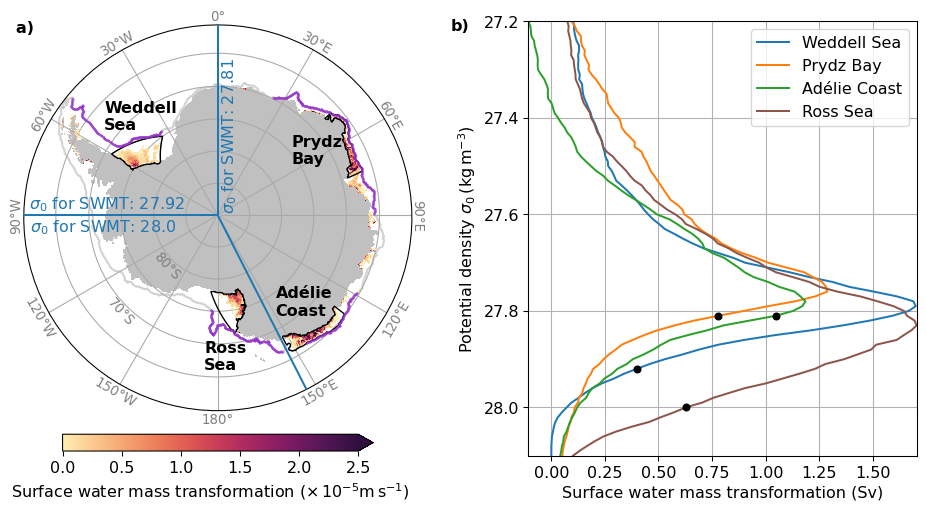

In [27]:
fig = plt.figure(figsize=(12, 7))
plt.subplots_adjust(wspace=.3)
padx, pady, width = (0.035, .025, 0.017)

proj = ccrs.PlateCarree()

ax = plt.subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], proj)
ax.set_boundary(circle, transform=ax.transAxes)

gl = ax.gridlines(draw_labels=False, color='darkgray')
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 30))
label_lon = ['0°', '180°', '60°E', '120°W', '120°E', '60°W',
             '90°E', '90°W', '30°E', '150°W', '150°E', '30°W']
rot_lon = [0, 0, -60, -60, 60, 60, -90, 90, -30, -30, 30, 30]
lat_lon_label = [-59.5, -58.7, -59.5, -58.5, -58.5, -59.2, -59.5, -59.2,
                 -59.5, -58.7, -58.7, -59.5]
for i, position in enumerate([0, 180, 60, -120, 120, -60, 90, -90,
                              30, -150, 150, -30]):
    ax.text(position, lat_lon_label[i], label_lon[i], rotation=rot_lon[i],
            horizontalalignment='center', verticalalignment='center',
            color='gray', fontsize=10, transform=proj)
for j in range(70, 90, 10):
    label = str(j) + '°S'
    ax.text(-135, -j+1.3, label, rotation=-48, horizontalalignment='center',
            verticalalignment='center', color='gray', fontsize=10,
            transform=proj)

ax.contourf(land_mask.xt_ocean.values,
            np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
            land_mask, colors='silver', levels=[0.5, 2],
            transform=proj, rasterized=True, zorder=2)
p2 = ax.pcolormesh(SWMT_fig1_merged.xt_ocean, SWMT_fig1_merged.yt_ocean,
                   SWMT_fig1_merged*1e5, vmin=0, vmax=2.5,
                   cmap=cmo.matter, transform=proj,
                   rasterized=True, zorder=3)
plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
            levels=[0, 1], colors = 'lightgray', linewidth=.7,
            transform=proj)
plt.plot([0, 0], [-90, -60], '-', color='tab:blue',
         transform=proj, zorder=7)
plt.plot([-90, -90], [-90, -60], '-', color='tab:blue',
         transform=proj, zorder=7)
plt.plot([-207, -207], [-90, -60], '-', color='tab:blue',
         transform=proj, zorder=7)

for a, area_text in enumerate(DSW_region['name']):
    plt.contour(mask_DSW.xt_ocean, mask_DSW.yt_ocean, mask_DSW[a, :, :],
                levels=[1], colors='k', linewidths=1, transform=proj, zorder=5)
    if area_text == 'Prydz':
        plt.plot(tracer_1000m.lon[:DSW_region['ind_iso_max'][a]],
                 tracer_1000m.lat[:DSW_region['ind_iso_max'][a]],
                 '.', color='darkorchid', markersize=.3, zorder=6,
                 transform=proj)
        plt.plot(tracer_1000m.lon[DSW_region['ind_iso_min'][a]:],
                 tracer_1000m.lat[DSW_region['ind_iso_min'][a]:],
                 '.', color='darkorchid', markersize=.3, zorder=6,
                 transform=proj)
    else:
        plt.plot(
            tracer_1000m.lon[DSW_region['ind_iso_min'][a]:
                             DSW_region['ind_iso_max'][a]],
            tracer_1000m.lat[DSW_region['ind_iso_min'][a]:
                             DSW_region['ind_iso_max'][a]],
            '.', color='darkorchid', markersize=.3, zorder=6,
            transform=proj)

plt.text(-.02, .98, 'a) ', fontweight='bold', transform=plt.gca().transAxes)
plt.text(-53, -68, 'Weddell\nSea', fontweight='bold', transform=proj)
plt.text(55, -76, 'Prydz\nBay', fontweight='bold', transform=proj)
plt.text(150, -72, 'Adélie\nCoast', fontweight='bold', transform=proj)
plt.text(-175, -66, 'Ross\nSea', fontweight='bold', transform=proj)

plt.text(-88, -61, '$\sigma_0$ for SWMT: 27.92', color='tab:blue',
         transform=proj)
plt.text(-95, -61, '$\sigma_0$ for SWMT: 28.0', color='tab:blue',
         transform=proj)
plt.text(20, -89, '$\sigma_0$ for SWMT: 27.81', color='tab:blue',
         rotation=90, transform=proj)

pos = ax.get_position()
cax = plt.axes([pos.xmin+.1*(pos.xmax-pos.xmin), pos.ymin-0.06,
                .8*(pos.xmax-pos.xmin), 0.025])
cb = plt.colorbar(p2, orientation='horizontal', cax=cax, extend='max')
cb.ax.set_xlabel('Surface water mass transformation ' +
                 r'($\times\,$10$^{-5}$m$\,$s$^{-1}$)')

# plt.subplot(15, 2, (6, 28))
# plt.subplot(10, 2, (4, 18))
plt.subplot(50, 2, (14, 96))

col = ['tab:blue', 'tab:orange', 'tab:green', 'tab:brown']
sig0_bins_offset = [-0.05, .05, .05, -.05]

for a, area_text in enumerate(DSW_region['name']):
    plt.plot(SWMT_all_densities.mean('time').sel(area=area_text),
             SWMT_all_densities.isopycnal_bins,
             color=col[a], label=DSW_region['name_long'][a])
    transp_sig0_bin = SWMT_all_densities.mean('time').sel(
        area=area_text).sel(isopycnal_bins=DSW_region['sig0_bins'][a],
                            method='nearest')
    plt.plot(transp_sig0_bin, DSW_region['sig0_bins'][a], 'k',
             marker='o', markersize=5)
plt.gca().invert_yaxis()
plt.autoscale(enable=True, axis='both', tight=True)
plt.grid()
plt.legend()

plt.text(-0.2, 0.98, string.ascii_lowercase[1] + ')', fontweight='bold',
         backgroundcolor='w', transform=plt.gca().transAxes)
plt.xlabel('Surface water mass transformation (Sv)')
plt.ylabel('Potential density $\sigma_0\,$(kg$\,$m$^{-3}$)')

if savefigures is True:
    plt.savefig(path_Plots + 'Fig1.png', dpi=300, bbox_inches="tight")
    plt.savefig(path_Plots + 'Fig1.pdf', dpi=300, bbox_inches="tight")

plt.show()

## Figure 2

In [28]:
tempo_mod = cmocean.tools.crop_by_percent(
    cmo.tempo, 20, which='max', N=None)
plt.cm.register_cmap(
    name='cmo_tempo_mod', cmap=tempo_mod)
cmo_tempo_mod = plt.cm.get_cmap('cmo_tempo_mod')

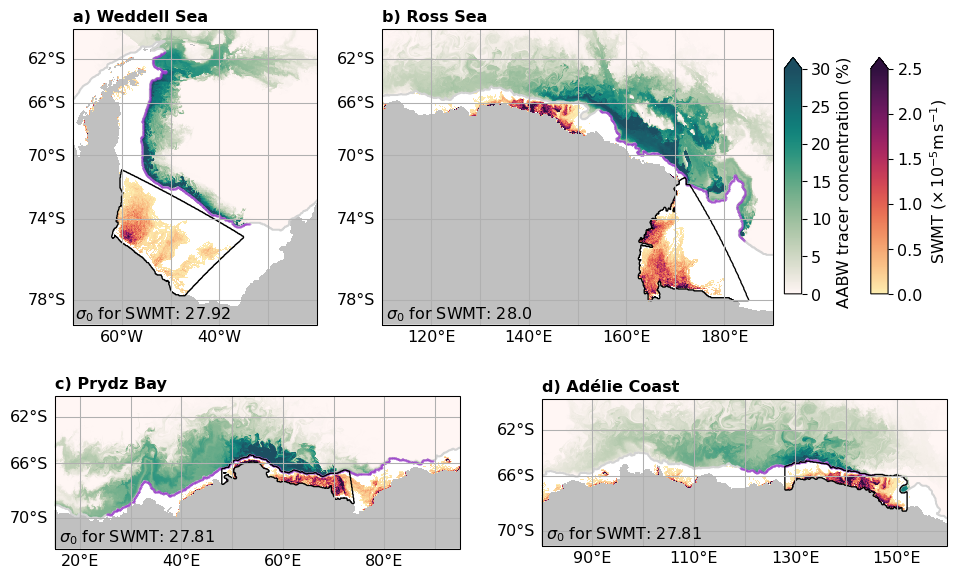

In [29]:
fig = plt.figure(figsize=(12, 8))
plt.subplots_adjust(wspace=0.2, hspace=0)

proj = ccrs.PlateCarree()

for a, area_text in enumerate(DSW_region['name']):
    if a == 0:
        minlon, maxlon, minlat, maxlat = [-70, -20, -79, -59]
        letter = string.ascii_lowercase[0] + ') '
    elif a == 1:
        minlon, maxlon, minlat, maxlat = [15, 95, -72, -60]
        letter = string.ascii_lowercase[2] + ') '
    elif a == 2:
        minlon, maxlon, minlat, maxlat = [80, 160, -71, -59]
        letter = string.ascii_lowercase[3] + ') '
    elif a == 3:
        minlon, maxlon, minlat, maxlat = [110, 190, -79, -59]
        letter = string.ascii_lowercase[1] + ') '
    
    if a == 0:
        ax = plt.subplot(2, 6, (1, 2), projection=ccrs.Mercator(
            min_latitude=-80, max_latitude=-50,
            latitude_true_scale=-70))
    elif a == 3:
        ax = plt.subplot(2, 6, (3, 5), projection=ccrs.Mercator(
            central_longitude=180, min_latitude=-80, max_latitude=-50,
            latitude_true_scale=-70))
    else:
        ax = plt.subplot(2, 2, a+2, projection=ccrs.Mercator(
            min_latitude=-80, max_latitude=-50,
            latitude_true_scale=-70))

    ax.set_extent([minlon, maxlon, minlat, maxlat], proj)
    gl = ax.gridlines(draw_labels=False, crs=proj)
    gl.left_labels = True
    # gl.bottom_labels = True
    if area_text == 'Weddell':
        gl.xlocator = mticker.FixedLocator(np.arange(-70, -10, 10))
        ax.set_xticks(np.arange(-60, -20, 20), crs=proj)
    elif area_text == 'Prydz':
        gl.xlocator = mticker.FixedLocator(np.arange(20, 100, 10))
        ax.set_xticks(np.arange(20, 100, 20), crs=proj)
    elif area_text == 'Adelie':
        gl.xlocator = mticker.FixedLocator(np.arange(90, 160, 10))
        ax.set_xticks(np.arange(90, 170, 20), crs=proj)
    elif area_text == 'Ross':
        gl.xlocator = mticker.FixedLocator(np.arange(120, 190, 10))
        ax.set_xticks(np.arange(120, 200, 20), crs=proj)
    ax.xaxis.set_major_formatter(LongitudeFormatter(
        dateline_direction_label=True))
    ax.tick_params(length=0)
    gl.ylocator = mticker.FixedLocator(np.arange(-78, -50, 4))
    
    ax.contourf(land_mask.xt_ocean.values,
                np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
                land_mask, colors='silver', levels=[0.5, 2],
                transform=proj, rasterized=True)
    
        
    p1 = ax.pcolormesh(tracer_all.xt_ocean, tracer_all.yt_ocean,
                       (100*tracer_all[a, :].where(shelf_mask == 0)),
                       vmin=0, vmax=30, cmap=cmo_tempo_mod, transform=proj,
                       rasterized=True)
    p2 = ax.pcolormesh(SWMT_fig1_merged.xt_ocean, SWMT_fig1_merged.yt_ocean,
                       SWMT_fig1_merged*1e5, vmin=0, vmax=2.5,
                       cmap=cmo.matter, transform=proj,
                       rasterized=True)
    plt.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean, shelf_mask.values,
                levels=[0, 1], colors = 'lightgray', linewidth=.7,
                transform=proj)
    if area_text == 'Prydz':
        plt.plot(tracer_1000m.lon[:DSW_region['ind_iso_max'][a]],
                 tracer_1000m.lat[:DSW_region['ind_iso_max'][a]],
                 '.', color='darkorchid', markersize=.4,
                 transform=proj)
        plt.plot(tracer_1000m.lon[DSW_region['ind_iso_min'][a]:],
                 tracer_1000m.lat[DSW_region['ind_iso_min'][a]:],
                 '.', color='darkorchid', markersize=.4,
                 transform=proj)
    else:
        plt.plot(
            tracer_1000m.lon[DSW_region['ind_iso_min'][a]:
                             DSW_region['ind_iso_max'][a]],
            tracer_1000m.lat[DSW_region['ind_iso_min'][a]:
                             DSW_region['ind_iso_max'][a]],
            '.', color='darkorchid', markersize=.4, transform=proj)
    plt.title(letter + DSW_region['name_long'][a], fontweight='bold',
              loc='left')
    if a == 0:
        plt.text(0.01, 0.02, '$\sigma_0$ for SWMT: 27.92',
                 transform=plt.gca().transAxes)
    elif a == 3:
        plt.text(0.01, 0.02, '$\sigma_0$ for SWMT: 28.0',
                 transform=plt.gca().transAxes)
    else:
        plt.text(0.01, 0.05, '$\sigma_0$ for SWMT: 27.81',
                 transform=plt.gca().transAxes)
    
    plt.contour(mask_DSW.xt_ocean, mask_DSW.yt_ocean, mask_DSW[a, :, :],
                levels=[1], colors='k', linewidths=1, transform=proj)
    
    if a == 3:
        pos = ax.get_position()
        cax = plt.axes([pos.xmax+.01, pos.ymin+0.04,
                        0.015, .8*(pos.ymax-pos.ymin)])
        cb = plt.colorbar(p1, cax=cax, orientation='vertical', extend='max')
        cb.ax.set_ylabel('AABW tracer concentration (%)')
        cax = plt.axes([pos.xmax+.085, pos.ymin+0.04,
                        0.015, .8*(pos.ymax-pos.ymin)])
        cb = plt.colorbar(p2, cax=cax, orientation='vertical', extend='max')
        cb.ax.set_ylabel(r'SWMT ($\times\,$10$^{-5}$m$\,$s$^{-1}$)')

if savefigures is True:
    plt.savefig(path_Plots + 'Fig2.png', dpi=300, bbox_inches="tight")
    plt.savefig(path_Plots + 'Fig2.pdf', dpi=300, bbox_inches="tight")

plt.show()

## Figure 3

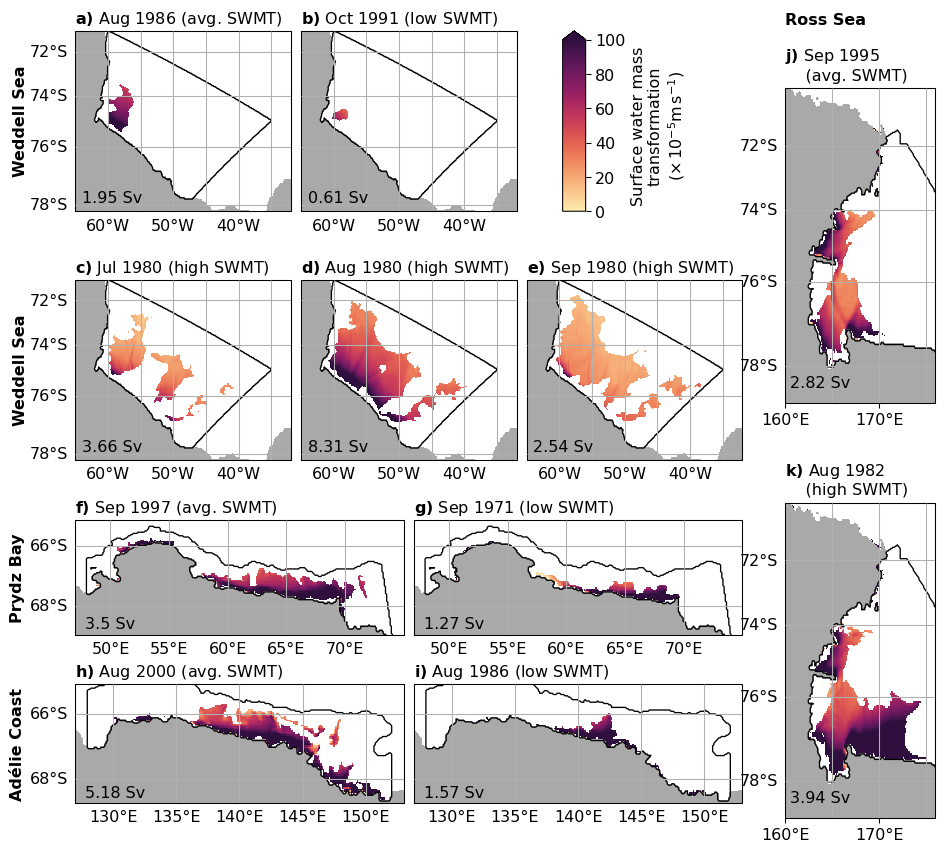

In [30]:
fig = plt.figure(figsize=(12, 11))
plt.subplots_adjust(wspace=.1, hspace=.25)

proj = ccrs.PlateCarree()

area_text_all = ['Weddell', 'Weddell', 'Weddell', 'Weddell', 'Weddell',
                 'Prydz', 'Prydz', 'Adelie', 'Adelie', 'Ross', 'Ross']
a_all = [0, 0, 0, 0, 0, 1, 1, 2, 2, 3, 3,]
yrs_all = [1986, 1991, 1980, 1980, 1980, 1997, 1971, 2000, 1986,
           1995, 1982,]
mth_all = [8, 10, 7, 8, 9, 9, 9, 8, 8, 9, 8]
s_all = [1, 3, 25, 27, 29, 49, 52, 65, 68, 15, 55]
str_all = ['avg.', 'low', 'high', 'high', 'high',
           'avg.', 'low', 'avg.', 'low', 'avg.', 'high']

for m in range(11):
    area_text = area_text_all[m]
    a = a_all[m]
    var = globals()['SWMT' + '_' + area_text[0]]
    yrs = yrs_all[m]
    mth = mth_all[m]
    s = s_all[m]
    str_SWMT = str_all[m]

    if area_text == 'Ross':
        ax = plt.subplot(10, 8, (s, s+25), projection=ccrs.Mercator(
            central_longitude=180, min_latitude=-80, max_latitude=-60,
            latitude_true_scale=-70))
    elif area_text == 'Weddell':
        ax = plt.subplot(10, 8, (s, s+17), projection=ccrs.Mercator(
            min_latitude=-80, max_latitude=-60, latitude_true_scale=-70))
    else:
        ax = plt.subplot(10, 8, (s, s+10), projection=ccrs.Mercator(
            min_latitude=-80, max_latitude=-60, latitude_true_scale=-70))

    if area_text == 'Weddell':
        ax.set_extent([-65, -32, -78.2, -71], proj)
    elif area_text == 'Prydz':
        ax.set_extent([47, 75, -68.9, -65.1], proj)
    elif area_text == 'Adelie':
        ax.set_extent([127, 153, -68.7, -65], proj)
    elif area_text == 'Ross':
        ax.set_extent([161, 176, -78.8, -70], proj)
    gl = ax.gridlines(draw_labels=False, crs=proj, zorder=6)
    gl.ylocator = mticker.FixedLocator(np.arange(-78, -60, 2))
    if area_text == 'Ross':
        gl.xlocator = mticker.FixedLocator(
            [165, 170, 175, 180, -165, -170, -175])
        ax.set_xticks([160, 170], crs=proj)
        ax.xaxis.set_major_formatter(LongitudeFormatter(
            dateline_direction_label=True))
    if m in [0, 2, 5, 7, 9, 10]:
        gl.left_labels = True
    if m < 9:
        gl.bottom_labels = True

    ax.contourf(land_mask.xt_ocean.values,
                np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
                land_mask, colors='darkgrey', levels=[0.5, 2],
                transform=proj, rasterized=True)

    p = plt.pcolormesh(
        var.xt_ocean, var.yt_ocean,
        var.sel(time=slice(str(yrs), str(yrs)),
                 isopycnal_bins=slice(DSW_region['sig0_bins'][a], None)).mean(
            'isopycnal_bins')[mth-1, :, :]*1e5, cmap=cmo.matter, vmin=0,
        vmax=100, transform=proj, rasterized=True, zorder=1)
    SWMT_amount = (var.sel(time=slice(str(yrs), str(yrs))).sel(
        isopycnal_bins=DSW_region['sig0_bins'][a], method='nearest')[
        mth-1, :, :] * area_t_DSW[a, :]/1e6).sum(['xt_ocean', 'yt_ocean']).values 
    plt.text(.03, .05, str(np.round(SWMT_amount, 2)) + ' Sv',
             zorder=10, transform=plt.gca().transAxes)
    plt.contour(mask_DSW.xt_ocean, mask_DSW.yt_ocean, mask_DSW[a, :, :],
                levels=[1], colors='k', linewidths=1, transform=proj, zorder=5)

    if m > 8:
        plt.title(r"$\bf{" + string.ascii_lowercase[m] + ')' + "}$" + ' ' +
                  calendar.month_abbr[mth] + ' ' + str(yrs) + '\n    (' +
                  str_SWMT + ' SWMT)', loc='left')
    else:
        plt.title(r"$\bf{" + string.ascii_lowercase[m] + ')'  + "}$" + ' ' +
                  calendar.month_abbr[mth] + ' ' + str(yrs) + ' (' +
                  str_SWMT + ' SWMT)', loc='left')
    if m in [0, 2]:
        plt.text(
            -.29, 0.5, DSW_region['name_long'][a], fontweight='bold',
            rotation=90, verticalalignment='center',
            transform=plt.gca().transAxes)
    elif m in [5, 7]:
        plt.text(
            -.2, 0.5, DSW_region['name_long'][a], fontweight='bold',
            rotation=90, verticalalignment='center',
            transform=plt.gca().transAxes)
        
    elif m == 9:
        plt.text(
            0, 1.2, DSW_region['name_long'][a], fontweight='bold',
            transform=plt.gca().transAxes)

    if s == 3:
        pos = ax.get_position()
        cax = plt.axes([pos.xmax+0.04, pos.ymin, 0.02, pos.ymax-pos.ymin])
        cb = plt.colorbar(p, cax=cax, orientation='vertical', extend='max')
        cb.ax.set_ylabel('Surface water mass\ntransformation\n' +
                         r'($\times\,$10$^{-5}$m$\,$s$^{-1}$)')

if savefigures is True:
    plt.savefig(path_Plots + 'Fig3.png', dpi=300, bbox_inches="tight")
    plt.savefig(path_Plots + 'Fig3.pdf', dpi=300, bbox_inches="tight")

plt.show()

## Figure 4

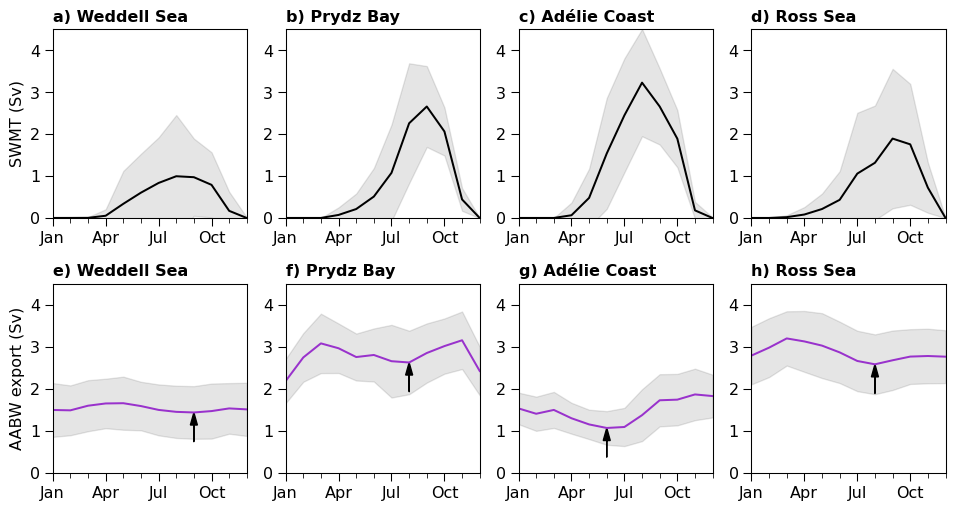

In [31]:
fig = plt.figure(figsize=(12, 6))
plt.subplots_adjust(hspace=0.35)

for a, area_text in enumerate(DSW_region['name']):
    plt.subplot(2, 4, a+1)
    plt.fill_between(
        np.arange(1, 13),
        SWMT_m[a, :].groupby('time.month').mean() +
        SWMT_m[a, :].groupby('time.month').std(),
        SWMT_m[a, :].groupby('time.month').mean() -
        SWMT_m[a, :].groupby('time.month').std(),
        color='k', alpha=.1)
    SWMT_m[a, :].groupby('time.month').mean().plot(color='k')
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.ylim(0, 4.5)
    plt.title('')
    plt.xlabel('')
    plt.title(string.ascii_lowercase[a] + ') ' + DSW_region['name_long'][a],
              fontweight='bold', loc='left')
    ax = plt.gca()
    ax.set_xticks(np.arange(1, 13, 3), [l for l in calendar.month_abbr[1::3]])
    ax.set_xticks(np.arange(1, 13), label='', minor=True)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=4)
    if a == 0:
        plt.ylabel('SWMT (Sv)')
        
    plt.subplot(2, 4, a+5)
    plt.fill_between(
        np.arange(1, 13),
        AABW_export_m[a, :].groupby('time.month').mean() +
        AABW_export_m[a, :].groupby('time.month').std(),
        AABW_export_m[a, :].groupby('time.month').mean() -
        AABW_export_m[a, :].groupby('time.month').std(),
        color='k', alpha=.1)
    AABW_export_m[a, :].groupby('time.month').mean().plot(color='darkorchid')
    plt.arrow(AABW_export_m[a, :].groupby('time.month').mean().sel(
        month=slice(4, 10)).argmin()+4,
              AABW_export_m[a, :].groupby('time.month').mean().sel(
                  month=slice(4, 10)).min()-.7,
              0, .4, fc='k', ec='k', head_width=.4, head_length=.3)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.ylim(0, 4.5)
    plt.title('')
    plt.xlabel('')
    plt.ylabel('')
    plt.title(string.ascii_lowercase[a+4] + ') ' + DSW_region['name_long'][a],
              fontweight='bold', loc='left')
    ax = plt.gca()
    ax.set_xticks(np.arange(1, 13, 3), [l for l in calendar.month_abbr[1::3]])
    ax.set_xticks(np.arange(1, 13), label='', minor=True)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=4)
    if a == 0:
        plt.ylabel('AABW export (Sv)')

if savefigures is True:
    plt.savefig(path_Plots + 'Fig4.png', dpi=300, bbox_inches="tight")
    plt.savefig(path_Plots + 'Fig4.pdf', dpi=300, bbox_inches="tight")

plt.show()

## Figure 5

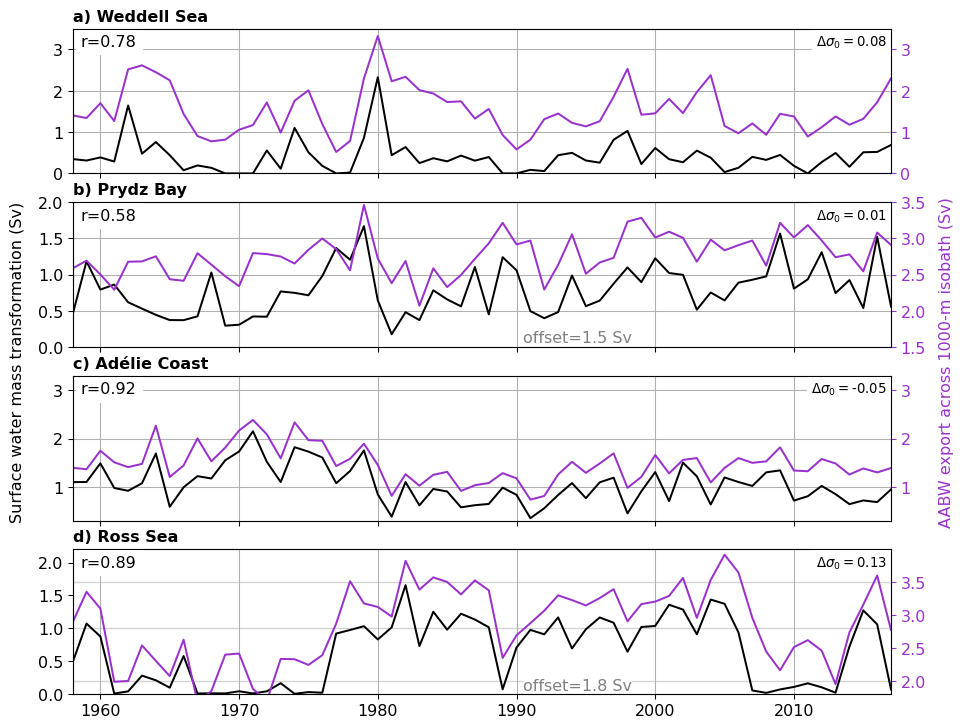

In [32]:
fig = plt.figure(figsize=(11, 9))
plt.subplots_adjust(hspace=0.2)

dsig0 = [0.08, 0.01, -0.05, 0.13]
for a, area_text in enumerate(DSW_region['name']):
    plt.subplot(4, 1, a+1)
    plt.plot(SWMT.time, SWMT.sel(area=area_text), color='k')

    r, p_val = correlation_3D(
        SWMT[a, :], AABW_export[a, :], dims='time')
    plt.title(string.ascii_lowercase[a] + ') ' + DSW_region['name_long'][a],
             fontweight='bold', loc='left')
    plt.text(0.01, 0.88, 'r=' + str(np.round(r.values, 2)),
             backgroundcolor='w', transform=plt.gca().transAxes)
    plt.text(.995, 0.88, r'$\Delta\sigma_0=$' + str(dsig0[a]),
             ha='right', backgroundcolor='w', fontsize=10,
             transform=plt.gca().transAxes)
    plt.autoscale(enable=True, axis='x', tight=True)
    if a < 3:
        plt.gca().set_xticklabels([])
    if a == 0:
        plt.ylim([0, 3.5])
        plt.grid(axis='both')
    elif a == 1:
        plt.ylim([0, 2])
        plt.grid(axis='both')
        plt.gca().set_xticklabels([])
        plt.text(0.55, 0.03, 'offset=' + str(1.5) + ' Sv', color='grey',
                 bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'),
                 transform=plt.gca().transAxes)
    elif a == 2:
        plt.ylim([.3, 3.3])
        plt.gca().set_xticklabels([])
        plt.grid(axis='both')
    elif a == 3:
        plt.ylim([0, 2.2])
        plt.yticks([0, 0.5, 1, 1.5, 2])
        plt.grid(axis='x')
        plt.axhline(1, color='lightgrey', linewidth=1, zorder=0)
        # gridlines for y=2 and y=3.5 on right axis
        plt.axhline(1.7, color='lightgrey', linewidth=1, zorder=0)
        plt.axhline(0.2, color='lightgrey', linewidth=1, zorder=0)
        plt.text(0.55, 0.03, 'offset=' + str(1.8) + ' Sv', color='grey', 
                 bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'),
                 transform=plt.gca().transAxes)

    ax2 = plt.gca().twinx()
    plt.plot(AABW_export.time, AABW_export[a, :], label=area_text,
             color='darkorchid')
    ax2.tick_params(axis='y', colors='darkorchid')

    if a == 0:
        plt.ylim([0, 3.5])
    elif a == 1:
        plt.ylim([1.5, 3.5])
    elif a == 2:
        plt.ylim([.3, 3.3])
    elif a == 3:
        plt.ylim([1.8, 4])
        plt.yticks([2, 2.5, 3, 3.5])
        plt.autoscale(enable=True, axis='x', tight=True)

ax = plt.gcf().add_subplot(111, frameon=False)
ax2 = ax.twinx()
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False,
               right=False)
ax.set_ylabel('Surface water mass transformation (Sv)', labelpad=10)
ax2.tick_params(labelcolor='none', top=False, bottom=False, left=False,
                right=False)
ax2.set_ylabel('AABW export across 1000-m isobath (Sv)', labelpad=10,
               color='darkorchid')
ax2.set_frame_on(False) 

if savefigures is True:
    plt.savefig(path_Plots + 'Fig5.png', dpi=300, bbox_inches="tight")
    plt.savefig(path_Plots + 'Fig5.pdf', dpi=300, bbox_inches="tight")

plt.show()

## Figure 6

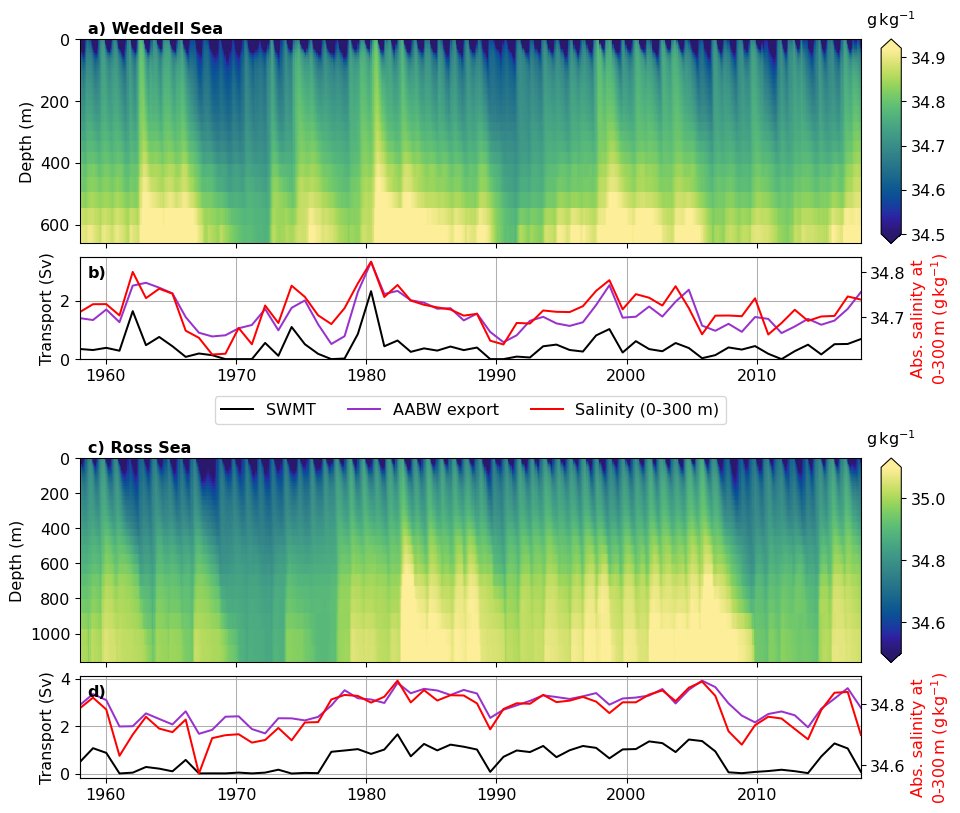

In [33]:
""" Weddell and Ross"""
fig, ax = plt.subplots(
    figsize=(10.5, 10), nrows=5,
    gridspec_kw={"height_ratios" : [2, 1, .7, 2, 1], "hspace":0.1})
ax[2].axis("off")
v_max = [34.92, 34.82, 34.84, 35.1]

for a in [0, 3]:
    plt.axes(ax[a])
    p = plt.pcolormesh(
        salt_DSW_mean.time.values, salt_DSW_mean.st_ocean,
        salt_DSW_mean[a, :, :].transpose(), cmap=cmo.haline,
        vmin=34.5, vmax=v_max[a], rasterized=True)
    if a == 0:
        plt.ylim(None, 660)
    plt.gca().invert_yaxis()
    plt.ylabel('Depth (m)')
    plt.text(0.01, 1.03, string.ascii_lowercase[np.int(2/3*a)] +
             ') ' + DSW_region['name_long'][a],
             fontweight='bold', transform=plt.gca().transAxes)
    plt.gca().set_xticklabels([])

    padx, pady, width = (0.02, .03, 0.02)
    pos = plt.gca().get_position()
    cax = plt.axes(
        [pos.xmax + padx, pos.ymin, width, (pos.ymax-pos.ymin)])
    plt.colorbar(p, cax=cax, extend='both')
    cax.set_title('g$\,$kg$^{-1}$', pad=10)

    plt.axes(ax[a+1])
    ln1 = plt.plot(
        SWMT.time+np.linspace(0, 1, 60), SWMT[a, :], 'k', label='SWMT')
    ln2 = plt.plot(AABW_export.time+np.linspace(0, 1, 60),
                   AABW_export[a, :], 'darkorchid', label='AABW export')
    plt.ylabel('Transport (Sv)')
    plt.text(0.01, .8, string.ascii_lowercase[np.int(2/3*a+1)] + ')',
              fontweight='bold', transform=plt.gca().transAxes)
    plt.autoscale(enable=True, axis='x', tight=True)
    if a == 0:
        plt.ylim([0, 3.5])
    elif a == 2:
        plt.ylim([.3, 2.8])
    plt.grid(axis='both')
    
    ax2 = plt.gca().twinx()
    ln3 = plt.plot(salt_DSW.time+np.linspace(0, 1, 60), salt_DSW[a, :],
                   'r', label='Salinity (0-300 m)')
    plt.ylabel('Abs. salinity at\n' + '0-300$\,$m (g$\,$kg$^{-1}$)',
               color='r', y=0.4)

    ax2.autoscale(enable=True, axis='x', tight=True)
    if a < 2:
        lns = ln1+ln2+ln3
        labs = [l.get_label() for l in lns]
        plt.legend(lns, labs, ncol=3, loc='center',
                   bbox_to_anchor=(0.5, -.5))

if savefigures is True:
    plt.savefig(path_Plots + 'Fig6.png', dpi=300, bbox_inches="tight")
    plt.savefig(path_Plots + 'Fig6.pdf', dpi=300, bbox_inches="tight")

plt.show()

## Figure 7

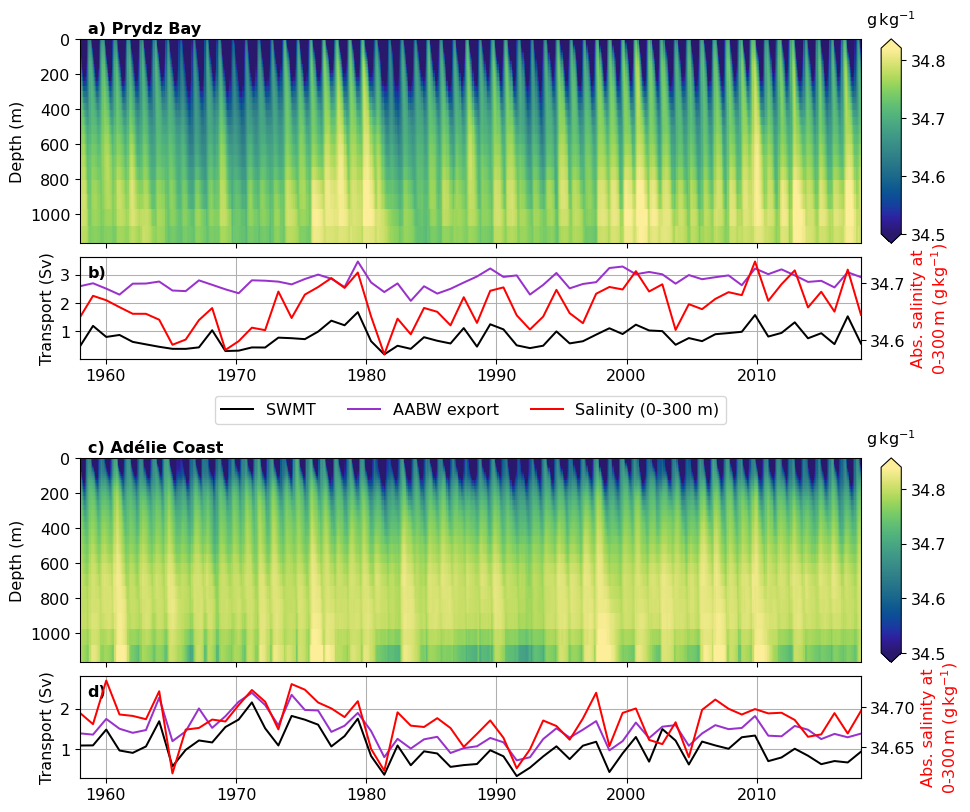

In [34]:
""" Prydz and Adelie"""
fig, ax = plt.subplots(
    figsize=(10.5, 10), nrows=5,
    gridspec_kw={"height_ratios" : [2, 1, .7, 2, 1], "hspace":0.1})
ax[2].axis("off")
v_max = [34.92, 34.82, 34.84, 35.1]

for a in [1, 2]:
    plt.axes(ax[(a-1)*3])
    p = plt.pcolormesh(
        salt_DSW_mean.time.values, salt_DSW_mean.st_ocean,
        salt_DSW_mean[a, :, :].transpose(), cmap=cmo.haline,
        vmin=34.5, vmax=v_max[a], rasterized=True)
    if a == 0:
        plt.ylim(None, 660)
    plt.gca().invert_yaxis()
    plt.ylabel('Depth (m)')
    plt.text(0.01, 1.03, string.ascii_lowercase[(a-1)*2] +
             ') ' + DSW_region['name_long'][a],
              fontweight='bold', transform=plt.gca().transAxes)
    plt.gca().set_xticklabels([])

    padx, pady, width = (0.02, .03, 0.02)
    pos = plt.gca().get_position()
    cax = plt.axes([pos.xmax + padx, pos.ymin, width, (pos.ymax-pos.ymin)])
    plt.colorbar(p, cax=cax, extend='both')
    cax.set_title('g$\,$kg$^{-1}$', pad=10)

    plt.axes(ax[(a-1)*3+1])
    ln1 = plt.plot(
        SWMT.time+np.linspace(0, 1, 60), SWMT[a, :], 'k', label='SWMT')
    ln2 = plt.plot(AABW_export.time+np.linspace(0, 1, 60),
                   AABW_export[a, :], 'darkorchid', label='AABW export')
    plt.ylabel('Transport (Sv)')
    plt.text(0.01, .8, string.ascii_lowercase[(a-1)*2+1] + ')',
              fontweight='bold', transform=plt.gca().transAxes)
    plt.autoscale(enable=True, axis='x', tight=True)
    if a == 0:
        plt.ylim([0, 3.5])
    elif a == 2:
        plt.ylim([.3, 2.8])
    plt.grid(axis='both')
    
    ax2 = plt.gca().twinx()
    ln3 = plt.plot(salt_DSW.time+np.linspace(0, 1, 60), salt_DSW[a, :],
                   'r', label='Salinity (0-300 m)')
    plt.ylabel('Abs. salinity at\n' + '0-300$\,$m (g$\,$kg$^{-1}$)',
               color='r')
    
    ax2.autoscale(enable=True, axis='x', tight=True)
    if a < 2:
        lns = ln1+ln2+ln3
        labs = [l.get_label() for l in lns]
        plt.legend(lns, labs, ncol=3, loc='center',
                   bbox_to_anchor=(0.5, -.5))

if savefigures is True:
    plt.savefig(path_Plots + 'Fig7.png', dpi=300, bbox_inches="tight")
    plt.savefig(path_Plots + 'Fig7.pdf', dpi=300, bbox_inches="tight")

plt.show()

## Figure 8

In [35]:
def box_outline_map(lon, lat):
    lon_plt = [lon[0]]
    lat_plt = [lat[0]]
    for l in range(1, len(lon)-1):
        if lon[l] == lon[l+1]:
            # same lon
            lon_plt += [lon[l]]
            lat_plt += [lat[l]]
        elif lat[l] == lat[l+1]:
            # different lon, same lat
            lon_temp = [l for l in np.arange(
                lon[l], lon[l+1], np.sign(lon[l+1]-lon[l])*.5)]
            lon_plt += lon_temp
            lat_plt +=  list(lat[l]*np.ones(len(lon_temp)))
        else:
            # different lon and lat
            lon_temp = [l for l in np.arange(
                lon[l], lon[l+1], np.sign(lon[l+1]-lon[l])*.5)]
            lon_plt += lon_temp[:-1]
            lat_plt += list(np.linspace(
                lat[l], lat[l+1], len(lon_temp)))[:-1]
    lon_plt += [lon[-1]]
    lat_plt += [lat[-1]]
    
    return lon_plt, lat_plt

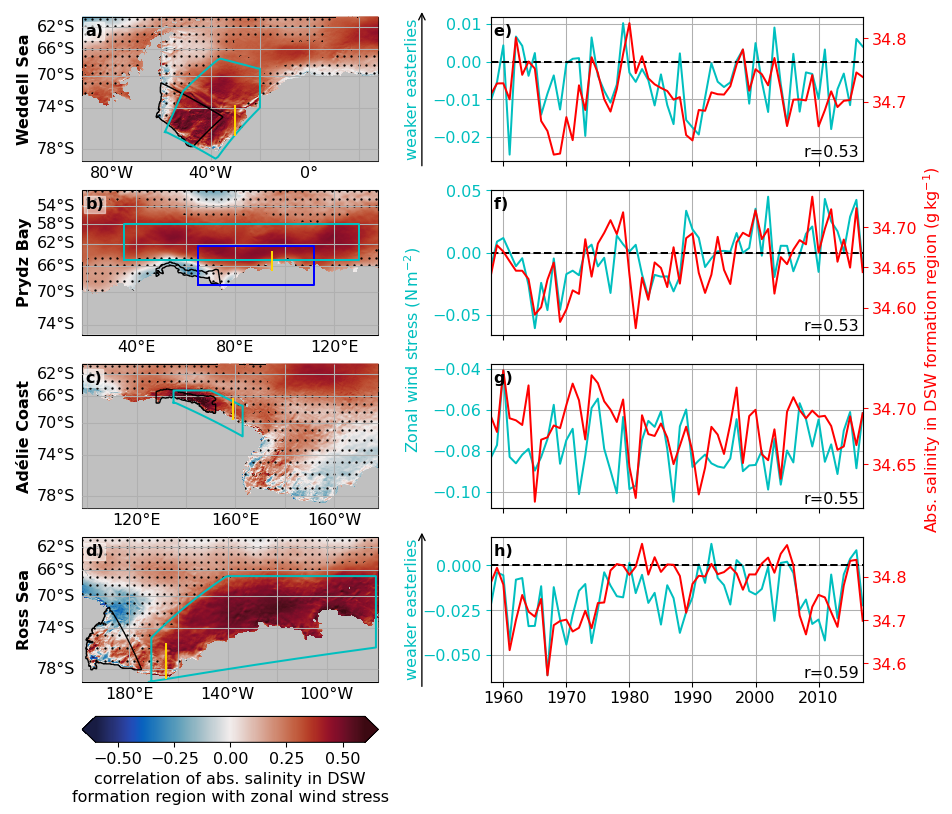

In [36]:
'''correlation of S in DSW with zonal wind stress in specific months'''
fig = plt.figure(figsize=(11, 9))
plt.subplots_adjust(wspace=.2, hspace=.2)

proj = ccrs.PlateCarree()
x, y = np.meshgrid(taux_cor.xt_ocean, taux_cor.yt_ocean)

for a, area_text in enumerate(DSW_region['name']):
    midlon = np.min(DSW_region['lon'][a])
    maxlon = midlon + 90
    minlon = midlon - 30
    if area_text == 'Ross':
        minlon += 31
        maxlon += 31
    midlon = (minlon+maxlon)/2
    minlat = -79
    maxlat = -60
    if area_text == 'Prydz':
        minlat = -75.1
        maxlat = -49
    midlat = (minlat + maxlat)/2
    
    if a >= 2:
        ax = plt.subplot(4, 2, a*2+1, projection=ccrs.Mercator(
            central_longitude=180, min_latitude=-80, max_latitude=-50,
            latitude_true_scale=-70))
    else:
        ax = plt.subplot(4, 2, a*2+1, projection=ccrs.Mercator(
            min_latitude=-80, max_latitude=-50,
            latitude_true_scale=-70))

    ax.set_extent([minlon, maxlon, minlat, maxlat], proj)
    gl = ax.gridlines(draw_labels=False, crs=proj, zorder=4)
    gl.left_labels = True
    if area_text == 'Weddell':
        gl.xlocator = mticker.FixedLocator(np.arange(-80, 40, 20))
        ax.set_xticks(np.arange(-80, 40, 40), crs=proj)
    elif area_text == 'Prydz':
        gl.xlocator = mticker.FixedLocator(np.arange(20, 160, 20))
        ax.set_xticks(np.arange(40, 160, 40), crs=proj)
    elif area_text == 'Adelie':
        gl.xlocator = mticker.FixedLocator(
            [100, 120, 140, 160, 180, -160])
        ax.set_xticks([120, 160, -160], crs=proj)
    elif area_text == 'Ross':
        gl.xlocator = mticker.FixedLocator(
            [160, 180, -160, -140, -120, -100])
        ax.set_xticks([180, -140, -100], crs=proj)
    ax.xaxis.set_major_formatter(LongitudeFormatter(
        dateline_direction_label=True))
    ax.tick_params(length=0)
    gl.ylocator = mticker.FixedLocator(np.arange(-78, -50, 4))
    
    ax.contourf(land_mask.xt_ocean.values,
                np.concatenate(([-90], land_mask.yt_ocean[1:].values)),
                land_mask, colors='silver', levels=[0.5, 2],
                transform=proj, rasterized=True, zorder=4)
    
    v_max = .6
    p = plt.pcolormesh(
        taux_cor.xt_ocean, taux_cor.yt_ocean, taux_cor[a, :, :],
        vmin=-v_max, vmax=v_max, cmap=cmo.balance,
        transform=proj, rasterized=True, zorder=1)
    plt.plot(x[::30, ::30], y[::30, ::30], 'k.', markersize=1.5,
             transform=proj, rasterized=True, zorder=2)
    plt.pcolormesh(taux_cor.xt_ocean, taux_cor.yt_ocean,
                   taux_cor[a, :, :].where(taux_pval[a, :, :] < 0.05),
                   vmin=-v_max, vmax=v_max, cmap=cmo.balance,
                   transform=proj, rasterized=True, zorder=3)
    plt.text(-.22, 0.5, DSW_region['name_long'][a], fontweight='bold',
             rotation=90, verticalalignment='center',
             transform=plt.gca().transAxes)
    t = plt.text(0.01, 0.87, string.ascii_lowercase[a] + ')',
             fontweight='bold', transform=plt.gca().transAxes, zorder=5)
    t.set_bbox(dict(pad=1, facecolor='white', alpha=0.5, edgecolor='white'))
    
    plt.contour(mask_DSW.xt_ocean, mask_DSW.yt_ocean, mask_DSW[a, :, :],
                levels=[1], colors='k', linewidths=1, transform=proj,
                zorder=5)
    if area_text == 'Prydz':
        lon_plt, lat_plt = box_outline_map(
            [65, 65, 112, 112, 65], [-69, -62.5, -62.5, -69, -69])
        ax.plot(lon_plt, lat_plt, 'b', transform=proj, zorder=6)

        lon_plt, lat_plt = box_outline_map(
            [35, 35, 130, 130, 35], [-65, -58, -58, -65, -65])
    else:
        lon_plt, lat_plt = box_outline_map(DSW_region['mask_taux_lon'][a],
                                           DSW_region['mask_taux_lat'][a])
    ax.plot(lon_plt, lat_plt, 'c', transform=proj, zorder=6)
    plt.plot([ds_timeseries.lon[a], ds_timeseries.lon[a]],
             [ds_timeseries.lat_min[a], ds_timeseries.lat_min[a]+3],
              color='gold', transform=proj, zorder=6)
    
    if a == 3:
        pos = ax.get_position()
        cax = plt.axes([pos.xmin, pos.ymin-0.07,
                        (pos.xmax-pos.xmin), 0.03])
        cb = plt.colorbar(p, cax=cax, orientation='horizontal', extend='both')
        cb.ax.set_xlabel('correlation of abs. salinity in DSW\nformation ' +
                         'region with zonal wind stress')
        
    plt.subplot(4, 2, a*2+2)

    plt.plot(taux.time, taux[a, :], color='c')
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.gca().tick_params(axis='y', colors='c')
    if a < 3:
        plt.gca().set_xticklabels([])
    plt.grid(axis='both')
    
    if a != 2:
        plt.axhline(0, color='k', linestyle='--')
    if (a == 0) or (a == 3):
        plt.annotate('', xy=(-.185, -.05), xycoords='axes fraction',
                     xytext=(-.185, 1.05),
                     arrowprops=dict(arrowstyle="<-", color='k'))
        plt.text(-.23, .5, 'weaker easterlies', color='c', rotation=90,
                 verticalalignment='center', transform=plt.gca().transAxes)

    ax2 = plt.gca().twinx()

    plt.plot(salt_DSW.time, salt_DSW[a, :], color='r')
    
    plt.text(0.01, 0.87, string.ascii_lowercase[a+4] + ') ',
              fontweight='bold', transform=plt.gca().transAxes)
    r, p_val = correlation_3D(taux[a, :], salt_DSW[a, :])
    plt.text(0.99, 0.03, 'r=' +
             str(np.round(r.values, 2)), ha='right',
             transform=plt.gca().transAxes)
    
    ax2.tick_params(axis='y', colors='r')
    plt.autoscale(enable=True, axis='x', tight=True)
    if a < 3:
        ax2.set_xticklabels([])

ax = plt.gcf().add_subplot(111, frameon=False)
ax2 = ax.twinx()
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False,
               right=False)
ax.set_ylabel('Zonal wind stress (N$\,$m$^{-2}$)', labelpad=-310, color='c')
ax2.tick_params(labelcolor='none', top=False, bottom=False, left=False,
                right=False)
ax2.set_ylabel('Abs. salinity in DSW formation region (g$\,$kg$^{-1}$)',
               labelpad=18, color='r')
ax2.set_frame_on(False) 

if savefigures is True:
    plt.savefig(path_Plots + 'Fig8.png', dpi=300, bbox_inches="tight")
    plt.savefig(path_Plots + 'Fig8.pdf', dpi=300, bbox_inches="tight")

plt.show()

## Bathymetry of Figure 9

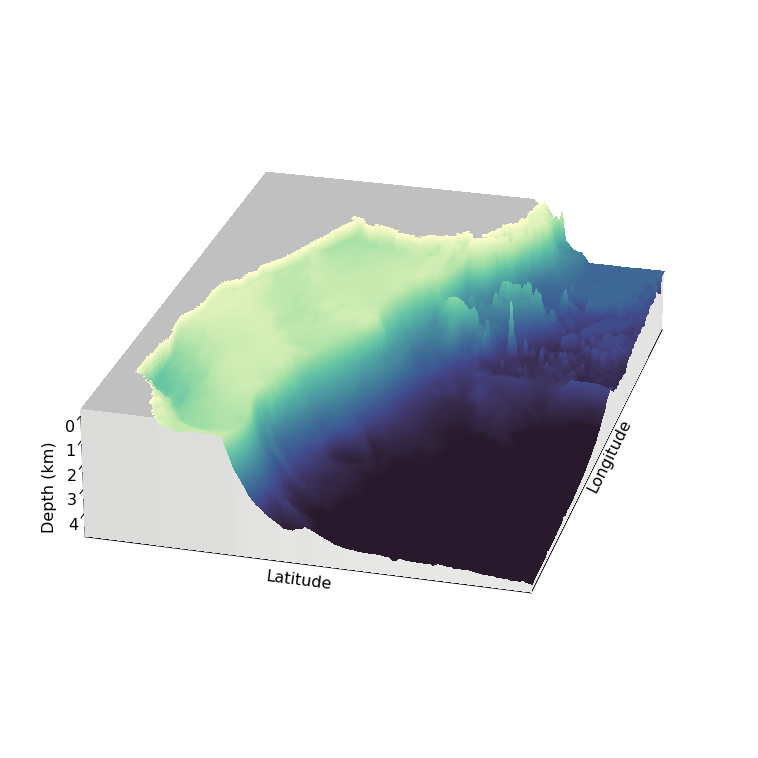

In [37]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d',box_aspect=(7,5,1.5))

stride_value = 1
cmap_deep = plt.cm.get_cmap(cmo.deep)
cmap_deep.set_under('silver')

# topo:
surf = ax.plot_surface(
    X, Y, ht_int.values, cmap=cmap_deep,rstride=stride_value,
    cstride=stride_value, linewidth=0, antialiased=False,
    vmin=0.01, vmax=4000)

# add front face of topo:
ax.plot_surface(
    Xf, Yf, np.where(Zf > 5200, 5200, Zf),
    rstride=stride_value, cstride=stride_value,linewidth=0, 
    antialiased=False, cmap=cmo.gray, vmin=-60000, vmax=10000)

# add side north face of topo:
ax.plot_surface(
    Xs, Ys, np.where(Zs > 5200, 5200, Zs),
    rstride=stride_value, cstride=stride_value,linewidth=0, 
    antialiased=False, cmap=cmo.gray, vmin=-60000, vmax=10000)

ax.set_zlabel('Depth (km)', rotation=90, labelpad=-6)
ax.zaxis.set_rotate_label(False) 
ax.set_zlim(4870,0)
ax.set_zticks([0, 1000, 2000, 3000, 4000], labels=['0', '1', '2', '3', '4'])
ax.tick_params(axis='z', which='major', pad=-3)

ax.set_ylabel('Latitude', labelpad=-10)
ax.set_ylim(-78.58, -65.22)
ax.set_yticks([])

ax.set_xlabel('Longitude', labelpad=-15)
ax.set_xlim(-66.3, -30)
ax.set_xticks([])
ax.tick_params()
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

# make the panes (background grid)transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax.view_init(25, 15)

if savefigures is True:
    plt.savefig(path_Plots + 'Bathy_for_Fig9.png',
                dpi=600, bbox_inches='tight', pad_inches=0.1)
    plt.savefig(path_Plots + 'Bathy_for_Fig9.pdf',
                dpi=600, bbox_inches='tight', pad_inches=0.1)

### Table 1: Mean and standard deviation of SWMT and AABW export

In [38]:
print('Mean and standard deviation of SWMT')
for a in range(4):
    print(SWMT.area[a].values, ':', np.round(SWMT[a, :].mean().values, 2),
          '+-', np.round(SWMT[a, :].std().values, 2), 'Sv (',
          np.round(SWMT[a, :].mean().values/SWMT.sum('area').mean().values*100, 1),
         '%)')
print('Circumpolar:', np.round(SWMT.sum('area').mean().values, 2),
      '+-', np.round(SWMT.sum('area').std().values, 2), 'Sv')
print('')
print('Mean and standard deviation of AABW export')
for a in range(4):
    print(AABW_export.area[a].values, ':',
          np.round(AABW_export[a, :].mean().values, 2),
          '+-', np.round(AABW_export[a, :].std().values, 2), 'Sv (',
          np.round(AABW_export[a, :].mean().values/
                   AABW_export.sum('area').mean().values*100, 1),
         '%)')
print('Circumpolar:', np.round(AABW_export.sum('area').mean().values, 2),
      '+-', np.round(AABW_export.sum('area').std().values, 2), 'Sv')

Mean and standard deviation of SWMT
Weddell : 0.4 +- 0.39 Sv ( 13.9 %)
Prydz : 0.78 +- 0.34 Sv ( 27.2 %)
Adelie : 1.05 +- 0.39 Sv ( 36.6 %)
Ross : 0.64 +- 0.5 Sv ( 22.2 %)
Circumpolar: 2.86 +- 0.76 Sv

Mean and standard deviation of AABW export
Weddell : 1.53 +- 0.58 Sv ( 17.7 %)
Prydz : 2.77 +- 0.28 Sv ( 32.1 %)
Adelie : 1.47 +- 0.36 Sv ( 17.0 %)
Ross : 2.85 +- 0.57 Sv ( 33.1 %)
Circumpolar: 8.62 +- 0.86 Sv


## Correlations: Table 2 and 3

In [39]:
var1 = salt_DSW
var1_str = 'Salinity in DSW region'
var2 = [SWMT, AABW_export, taux, ice_transp, area_open_water]
var2_str = ['SWMT', 'AABW export', 'zonal wind', 'ice transport', 'area of open water']
for n in range(len(var2)):
    print('Correlation between ' + var1_str +  ' and ' + var2_str[n])
    for a, area_text in enumerate(DSW_region['name']):
        r, p_val, p_str, N_eff = correlation_3D(
            var1[a, :], var2[n][a, :], dims='time', return_p_value_text_Neff=True)
        print( area_text + ': '  + 'r=' + str(np.round(r.values, 2)) + ' (' + p_str +
              ', eff.DoF=' + str(np.int(N_eff.values)) + ')')
    print('')

Correlation between Salinity in DSW region and SWMT
Weddell: r=0.8 (p<0.01, eff.DoF=46)
Prydz: r=0.92 (p<0.01, eff.DoF=48)
Adelie: r=0.76 (p<0.01, eff.DoF=48)
Ross: r=0.92 (p<0.01, eff.DoF=36)

Correlation between Salinity in DSW region and AABW export
Weddell: r=0.82 (p<0.01, eff.DoF=38)
Prydz: r=0.64 (p<0.01, eff.DoF=48)
Adelie: r=0.73 (p<0.01, eff.DoF=47)
Ross: r=0.9 (p<0.01, eff.DoF=33)

Correlation between Salinity in DSW region and zonal wind
Weddell: r=0.53 (p<0.01, eff.DoF=56)
Prydz: r=0.53 (p<0.01, eff.DoF=49)
Adelie: r=0.55 (p<0.01, eff.DoF=49)
Ross: r=0.59 (p<0.01, eff.DoF=48)

Correlation between Salinity in DSW region and ice transport
Weddell: r=-0.37 (p<0.01, eff.DoF=55)
Prydz: r=-0.31 (p<0.05, eff.DoF=49)
Adelie: r=-0.47 (p<0.01, eff.DoF=49)
Ross: r=-0.45 (p<0.01, eff.DoF=51)

Correlation between Salinity in DSW region and area of open water
Weddell: r=0.49 (p<0.01, eff.DoF=46)
Prydz: r=0.48 (p<0.01, eff.DoF=48)
Adelie: r=0.56 (p<0.01, eff.DoF=50)
Ross: r=0.6 (p<0.01, e

## Correlations in text

### dominant time scales of variability

In [40]:
def periodogram(data, dt, unit):
    # following 
    # https://tiofaizintio.medium.com/extract-seasonality-patterns-from-climate-
    # data-with-fast-fourier-transform-fft-de479303f01
    # dt is time step of data
    n = data.shape[0]  # length of time series
    F = fft(data)  # result of the FFT
    # sample frequency (frequency bin centers in cycles per unit
    # of the sample spacing (with zero at the start))
    w = fftfreq(n, dt)
    # time array with an increasing value from 1 until n (data length)
    t = np.linspace(1, n, n)
    # period (1/frequ) with half the length of the original time series
    T = n/t[0:int(n/2-1)]
    # select only indices for elements that correspond to positive frequencies
    indices = np.where(w > 0)
    # select only indices for elements that correspond to positive frequencies
    w_pos = abs(w[indices])
    # select only indices for elements that correspond to positive frequencies
    F_pos = abs(F[indices])
    
    return F_pos, T, unit

In [41]:
var = [SWMT, AABW_export]
var_str = ['SWMT', 'AABW export']
for a, area_text in enumerate(DSW_region['name']):
    print(area_text)
    for v in range(len(var)):
        fft_F, fft_T, unit = periodogram(
            data=var[v][a, :].values, dt=1, unit='years')
        std_orig = var[v][a, :].std().values

        """Each time series contains auto-regressive order 1 (i.e., red noise)
        and a white noise (normally distributed random noise). """
        np.random.seed(999)
        norm_fft_F = np.ones((len(fft_F), 10000))
        for n in range(norm_fft_F.shape[1]):
            nn = np.random.normal(size=60)
            nn = nn / np.std(nn) * std_orig
            fft_F_n, fft_T_n, unit = periodogram(data=nn, dt=1, unit='years')
            norm_fft_F[:, n] = fft_F_n
        quant_95 = np.quantile(norm_fft_F, .95, axis=1)
        quant_90 = np.quantile(norm_fft_F, .9, axis=1)

        peak_T_95 = np.where((fft_F > quant_95) & (fft_T <= 10), fft_T, np.nan)
        peak_T_95 = peak_T_95[~np.isnan(peak_T_95)]
        peak_F_95 = np.where((fft_F > quant_95) & (fft_T <= 10), fft_F, np.nan)
        peak_F_95 = peak_F_95[~np.isnan(peak_F_95)]

        peak_T_90 = np.where((fft_F > quant_90) & (fft_T <= 10), fft_T, np.nan)
        peak_T_90 = peak_T_90[~np.isnan(peak_T_90)]
        peak_F_90 = np.where((fft_F > quant_90) & (fft_T <= 10), fft_F, np.nan)
        peak_F_90 = peak_F_90[~np.isnan(peak_F_90)]

        print('peaks of ' + var_str[v] + ' significant at 95% at: ' +
              np.array2string(np.round(peak_T_95, 1), separator=', ')[1:-1] +
              ' years/cycle with a magnitude of ' +
              np.array2string(np.round(peak_F_95, 1), separator=', ')[1:-1])
        print('peaks of ' + var_str[v] + ' significant at 90% at: ' +
              np.array2string(np.round(peak_T_90, 1), separator=', ')[1:-1] +
              ' years/cycle with a magnitude of ' +
              np.array2string(np.round(peak_F_90, 1), separator=', ')[1:-1])
    print('')

Weddell
peaks of SWMT significant at 95% at: 6. years/cycle with a magnitude of 5.8
peaks of SWMT significant at 90% at: 8.6, 6.  years/cycle with a magnitude of 4.8, 5.8
peaks of AABW export significant at 95% at: 6. years/cycle with a magnitude of 7.8
peaks of AABW export significant at 90% at: 6. years/cycle with a magnitude of 7.8

Prydz
peaks of SWMT significant at 95% at: 10. years/cycle with a magnitude of 5.3
peaks of SWMT significant at 90% at: 10. ,  3.8 years/cycle with a magnitude of 5.3, 4.1
peaks of AABW export significant at 95% at: 2.5 years/cycle with a magnitude of 3.9
peaks of AABW export significant at 90% at: 10. ,  2.5 years/cycle with a magnitude of 3.4, 3.9

Adelie
peaks of SWMT significant at 95% at:  years/cycle with a magnitude of 
peaks of SWMT significant at 90% at: 3.8 years/cycle with a magnitude of 4.6
peaks of AABW export significant at 95% at:  years/cycle with a magnitude of 
peaks of AABW export significant at 90% at:  years/cycle with a magnitude of

### Correlations between SWMT and AABW export

In [42]:
var1 = SWMT
var1_str = 'SWMT'
var2 = [AABW_export]
var2_str = ['AABW export']
for n in range(len(var2)):
    print('Correlation between ' + var1_str +  ' and ' + var2_str[n])
    for a, area_text in enumerate(DSW_region['name']):
        r, p_val, p_str, N_eff = correlation_3D(
            var1[a, :], var2[n][a, :], dims='time', return_p_value_text_Neff=True)
        print( area_text + ': '  + 'r=' + str(np.round(r.values, 3)) + ' (' + p_str +
              ', eff.DoF=' + str(np.int(N_eff.values)) + ')')

Correlation between SWMT and AABW export
Weddell: r=0.775 (p<0.01, eff.DoF=46)
Prydz: r=0.585 (p<0.01, eff.DoF=49)
Adelie: r=0.92 (p<0.01, eff.DoF=45)
Ross: r=0.892 (p<0.01, eff.DoF=32)


### Correlations between differen formation regions

In [43]:
var = [SWMT, AABW_export]
var_str = ['SWMT', 'AABW export']

for n in range(len(var)):
    print('Correlation of ' + var_str[n] + ' between all four regions')
    for aa, area_text in enumerate(DSW_region['name'][:-1]):
        for a, area_text in enumerate(DSW_region['name'][aa+1:]):
            a += aa+1
            r, p_val, p_str, N_eff = correlation_3D(
                var[n][aa, :], var[n][a, :], dims='time', return_p_value_text_Neff=True)
            print(DSW_region['name'][aa] + ' vs ' + area_text + ': '  + 'r=' +
                  str(np.round(r.values, 3)) + ' (' + p_str +
                  ', eff.DoF=' + str(np.int(N_eff.values)) + ')')
    print('')

Correlation of SWMT between all four regions
Weddell vs Prydz: r=0.013 (not sign., eff.DoF=48)
Weddell vs Adelie: r=-0.041 (not sign., eff.DoF=47)
Weddell vs Ross: r=0.039 (not sign., eff.DoF=46)
Prydz vs Adelie: r=0.226 (not sign., eff.DoF=48)
Prydz vs Ross: r=-0.013 (not sign., eff.DoF=46)
Adelie vs Ross: r=-0.313 (p<0.05, eff.DoF=41)

Correlation of AABW export between all four regions
Weddell vs Prydz: r=0.022 (not sign., eff.DoF=47)
Weddell vs Adelie: r=-0.109 (not sign., eff.DoF=40)
Weddell vs Ross: r=0.194 (not sign., eff.DoF=36)
Prydz vs Adelie: r=0.255 (not sign., eff.DoF=47)
Prydz vs Ross: r=-0.144 (not sign., eff.DoF=46)
Adelie vs Ross: r=-0.422 (p<0.01, eff.DoF=38)



### Correlations between SWMT and ice growth

In [44]:
var1 = SWMT
var1_str = 'SWMT'
var2 = [yearly_sum(ice_growth_swmt)[:, :60], yearly_sum(ice_growth_DSW)[:, :60]]
var2_str = ['Ice growth in area of SWMT', 'Ice growth in DSW formation region']
for n in range(len(var2)):
    print('Correlation between ' + var1_str +  ' and ' + var2_str[n])
    for a, area_text in enumerate(DSW_region['name']):
        r, p_val, p_str, N_eff = correlation_3D(
            var1[a, :], var2[n][a, :], dims='time', return_p_value_text_Neff=True)
        print( area_text + ': '  + 'r=' + str(np.round(r.values, 3)) + ' (' + p_str +
              ', eff.DoF=' + str(np.int(N_eff.values)) + ')')
    print('')

Correlation between SWMT and Ice growth in area of SWMT
Weddell: r=0.897 (p<0.01, eff.DoF=48)
Prydz: r=0.949 (p<0.01, eff.DoF=49)
Adelie: r=0.916 (p<0.01, eff.DoF=48)
Ross: r=0.927 (p<0.01, eff.DoF=37)

Correlation between SWMT and Ice growth in DSW formation region
Weddell: r=0.471 (p<0.01, eff.DoF=50)
Prydz: r=0.118 (not sign., eff.DoF=49)
Adelie: r=-0.065 (not sign., eff.DoF=48)
Ross: r=-0.047 (not sign., eff.DoF=46)



### Correlations between zonal wind stress and SAM and Amundsen Sea Low index

In [45]:
path_SLP = ('/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/' +
            'atmos/3hrPt/psl/gr/v20190429/')
SLP = xr.open_mfdataset(
    path_SLP + 'psl_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_*.nc').psl

#### SAM index

In [46]:
def normalize_1D(da):
    da = (da - da.mean()) / da.std()
    return da

In [47]:
%%time
SLP_40S = normalize_1D(SLP.sel(lat=-40, method='nearest').mean('lon')).resample(
    time='M', label='left', loffset=timedelta(days=15)).mean()
SLP_65S = normalize_1D(SLP.sel(lat=-65, method='nearest').mean('lon')).resample(
    time='M', label='left', loffset=timedelta(days=15)).mean()

SLP_40S_JF = yearly_mean(SLP_40S.sel(time=SLP_40S.time.dt.month.isin([1, 2])))[:-2]
SLP_65S_JF = yearly_mean(SLP_65S.sel(time=SLP_65S.time.dt.month.isin([1, 2])))[:-2]
SAM_JF = (SLP_40S_JF - SLP_65S_JF).compute()

CPU times: user 13.3 s, sys: 2.56 s, total: 15.8 s
Wall time: 2min 25s


In [48]:
var1 = taux[1, :]
var1_str = 'zonal wind (Jan-Feb)'
var2 = SAM_JF
var2_str = 'SAM (Jan-Feb)'
print('Correlation between ' + var1_str +  ' and ' + var2_str)
a, area_text = 1, 'Prydz'

r, p_val, p_str, N_eff = correlation_3D(
    var1, var2, dims='time', return_p_value_text_Neff=True)
print( area_text + ': '  + 'r=' + str(np.round(r.values, 2)) + ' (' + p_str +
      ', eff.DoF=' + str(np.int(N_eff.values)) + ')')

Correlation between zonal wind (Jan-Feb) and SAM (Jan-Feb)
Prydz: r=0.75 (p<0.01, eff.DoF=49)


#### Amundsen Sea Low Index
Minimum of monthly SLP in 180-310E, 60-75S following Turner et al. (2013)

In [49]:
%%time
SLP_PA = SLP.sel(lat=slice(-75, -60), lon=slice(180, 310)) / 100
SLP_PA = SLP_PA.resample(time='M', label='left', loffset=timedelta(days=15)).mean()

ASL = SLP_PA.min(['lon', 'lat']).compute()
ASL_Jan_Jun = yearly_mean(ASL.sel(time=ASL.time.dt.month.isin([1, 2, 3, 4, 5, 6])))[:-2]

CPU times: user 9.56 s, sys: 1.58 s, total: 11.1 s
Wall time: 1min 52s


In [50]:
var1 = taux[3, :]
var1_str = 'zonal wind (Jan-Jun)'
var2 = ASL_Jan_Jun
var2_str = 'ASL (Jan-Jun)'
print('Correlation between ' + var1_str +  ' and ' + var2_str)
a, area_text = 3, 'Ross'

r, p_val, p_str, N_eff = correlation_3D(
    var1, var2, dims='time', return_p_value_text_Neff=True)
print( area_text + ': '  + 'r=' + str(np.round(r.values, 3)) + ' (' + p_str +
      ', eff.DoF=' + str(np.int(N_eff.values)) + ')')

Correlation between zonal wind (Jan-Jun) and ASL (Jan-Jun)
Ross: r=0.142 (not sign., eff.DoF=49)


### Correlations between zonal wind stress and sea ice transport

In [51]:
var1 = taux
var1_str = 'zonal wind'
var2 = [ice_transp]
var2_str = ['ice transport']

for n in range(len(var2)):
    print('Correlation between ' + var1_str +  ' and ' + var2_str[n])
    for a, area_text in enumerate(DSW_region['name']):
        if a == 0:
            r, p_val, p_str, N_eff = correlation_3D(
                var1[a, 1:], var2[n][a, 1:], dims='time', return_p_value_text_Neff=True)
        else:
            r, p_val, p_str, N_eff = correlation_3D(
                var1[a, :], var2[n][a, :], dims='time', return_p_value_text_Neff=True)
        print( area_text + ': '  + 'r=' + str(np.round(r.values, 2)) + ' (' + p_str +
              ', eff.DoF=' + str(np.int(N_eff.values)) + ')')
    print('')

Correlation between zonal wind and ice transport
Weddell: r=-0.49 (p<0.01, eff.DoF=48)
Prydz: r=-0.15 (not sign., eff.DoF=49)
Adelie: r=-0.45 (p<0.01, eff.DoF=49)
Ross: r=-0.59 (p<0.01, eff.DoF=50)



In [52]:
var1 = taux_Prydz
var1_str = 'zonal wind (in blue box)'
var2 = ice_transp
var2_str = 'ice transport'
print('Correlation between ' + var1_str +  ' and ' + var2_str)
a, area_text = 1, 'Prydz'

r, p_val, p_str, N_eff = correlation_3D(
    var1, var2[a, :], dims='time', return_p_value_text_Neff=True)
print( area_text + ': '  + 'r=' + str(np.round(r.values, 2)) + ' (' + p_str +
  ', eff.DoF=' + str(np.int(N_eff.values)) + ')')

Correlation between zonal wind (in blue box) and ice transport
Prydz: r=-0.43 (p<0.01, eff.DoF=50)


### Correlations between salinity in DSW region and salt advection in the Ross Sea

In [53]:
var1 = salt_adv
var1_str = 'salt advection'
var2 = salt_DSW
var2_str = 'Salinity in DSW region'
print('Correlation between ' + var1_str +  ' and ' + var2_str)
a, area_text = 3, 'Ross'

r, p_val, p_str, N_eff = correlation_3D(
    var1, var2[a, :], dims='time', return_p_value_text_Neff=True)
print( area_text + ': '  + 'r=' + str(np.round(r.values, 2)) + ' (' + p_str +
  ', eff.DoF=' + str(np.int(N_eff.values)) + ')')

Correlation between salt advection and Salinity in DSW region
Ross: r=0.58 (p<0.01, eff.DoF=49)


## Appendix figure 1

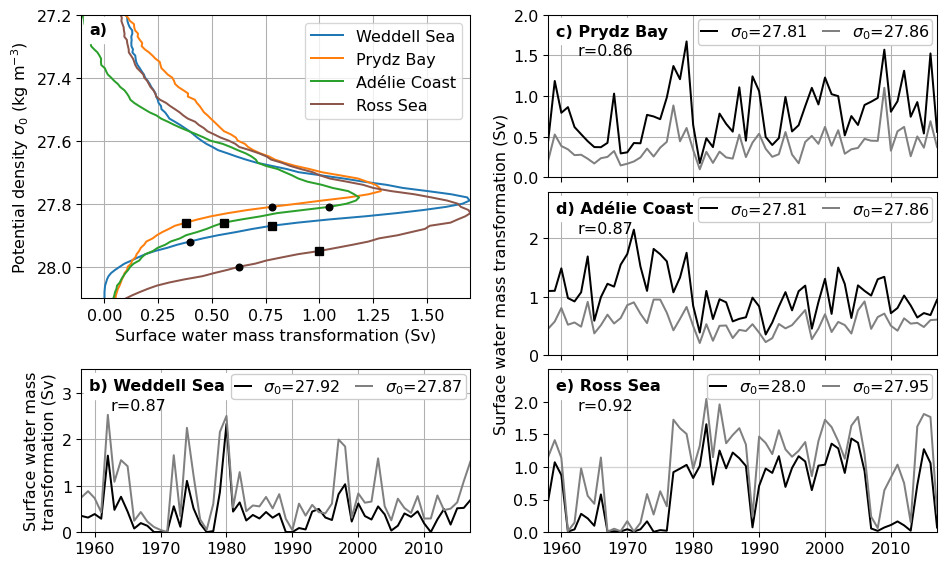

In [54]:
fig = plt.figure(figsize=(11.5, 7))
plt.subplots_adjust(hspace=.09, wspace=.2)
col = ['tab:blue', 'tab:orange', 'tab:green', 'tab:brown']
sig0_bins_offset = [-0.05, .05, .05, -.05]

plt.subplot(20, 2, (1, 21))
for a, area_text in enumerate(DSW_region['name']):
    plt.plot(SWMT_all_densities.mean('time').sel(area=area_text),
             SWMT_all_densities.isopycnal_bins,
             color=col[a], label=DSW_region['name_long'][a])
    transp_sig0_bin = SWMT_all_densities.mean('time').sel(area=area_text).sel(
        isopycnal_bins=DSW_region['sig0_bins'][a], method='nearest')
    transp_sig0_bin_offset = SWMT_all_densities.mean('time').sel(area=area_text).sel(
        isopycnal_bins=DSW_region['sig0_bins'][a]+sig0_bins_offset[a], method='nearest')
    plt.plot(transp_sig0_bin, DSW_region['sig0_bins'][a], 'k', marker='o', markersize=5)
    plt.plot(transp_sig0_bin_offset, DSW_region['sig0_bins'][a]+sig0_bins_offset[a],
             's', markersize=6, color='k')
plt.gca().invert_yaxis()
plt.autoscale(enable=True, axis='both', tight=True)
plt.grid()
plt.legend()

plt.text(0.02, 0.93, string.ascii_lowercase[0] + ')',
         fontweight='bold', backgroundcolor='w', transform=plt.gca().transAxes)
plt.xlabel('Surface water mass transformation (Sv)')
plt.ylabel('Potential density $\sigma_0$ (kg m$^{-3}$)')

sig0_bins_offset = [-0.05, .05, .05, -.05]
for a, area_text in enumerate(DSW_region['name']):
    if a == 0:
        plt.subplot(3, 2, 5)
    else:
        plt.subplot(3, 2, a*2)
    plt.plot(SWMT.time, SWMT.sel(area=area_text), color='k',
             label = '$\sigma_0$=' + str(np.round(
                 SWMT.sel(area=area_text).isopycnal_bins.values, 2)))
    plt.plot(SWMT.time, SWMT_all_densities[:-1, :, a].sel(
        isopycnal_bins=DSW_region['sig0_bins'][a]+sig0_bins_offset[a],
        method='nearest'), color='grey',
            label = '$\sigma_0$=' + str(np.round(SWMT_all_densities[:-1, :, a].sel(
                isopycnal_bins=DSW_region['sig0_bins'][a]+sig0_bins_offset[a],
                method='nearest').isopycnal_bins.values, 2)))

    r, p_val = correlation_3D(
        SWMT[a, :], SWMT_all_densities[:-1, :, a].sel(
            isopycnal_bins=DSW_region['sig0_bins'][a]+sig0_bins_offset[a],
            method='nearest'), dims='time')
    plt.text(0.02, 0.87, string.ascii_lowercase[a+1] + ') ' + DSW_region['name_long'][a],
             fontweight='bold', backgroundcolor='w', transform=plt.gca().transAxes)
    plt.text(0.075, 0.75, 'r=' + str(np.round(r.values, 2)),
             transform=plt.gca().transAxes)
    plt.autoscale(enable=True, axis='x', tight=True)
    plt.legend(ncol=2, loc='upper right', handlelength=1, framealpha=1,
               columnspacing=1, borderaxespad=.3, borderpad=.2)

    if a == 0:
        plt.ylim([0, 3.5])
        plt.ylabel('Surface water mass\ntransformation (Sv)')
        plt.grid(axis='both')
    elif a == 1:
        plt.ylim([0, 2])
        plt.grid(axis='both')
        plt.gca().set_xticklabels([])
    elif a == 2:
        plt.ylim([0, 2.8])
        plt.gca().set_xticklabels([])
        plt.ylabel('Surface water mass transformation (Sv)', labelpad=15)
        plt.grid(axis='both')
    elif a == 3:
        plt.ylim([0, 2.5])
        plt.yticks([0, 0.5, 1, 1.5, 2])
        plt.grid(axis='x')
        plt.plot(SWMT.time, np.ones(60), color='lightgrey', linewidth=1, zorder=0)


if savefigures is True:
    plt.savefig(path_Plots + 'FigA1.png', dpi=300, bbox_inches="tight")
    plt.savefig(path_Plots + 'FigA1.pdf', dpi=300, bbox_inches="tight")

plt.show()

## Appendix figure 2

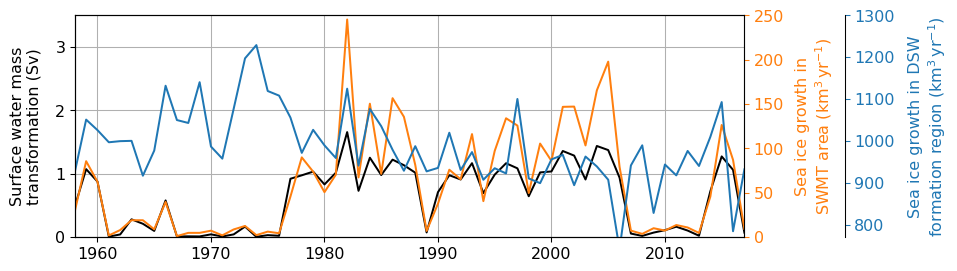

In [55]:
fig = plt.figure(figsize=(9, 3))

a, area_text = 3, 'Ross'
    
plt.plot(SWMT.time, SWMT[a, :], color='k')
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Surface water mass\ntransformation (Sv)', labelpad=10)
plt.ylim([0, 3.5])
plt.grid(axis='both')

ax = plt.gca()
ax2 = ax.twinx()
ax3 = ax.twinx()
# Offset the right spine of ax3.  The ticks and label have already been
# placed on the right by twinx above.
ax3.spines.right.set_position(("axes", 1.15))

ax2.plot(SWMT.time, yearly_sum(ice_growth_swmt)[a, :-1], color='tab:orange')
ax2.set_ylim(0, 250)
ax2.tick_params(axis='y', colors='tab:orange')
ax2.set_ylabel('Sea ice growth in\nSWMT area (km$^3\,$yr$^{-1}$)',
               labelpad=8, color='tab:orange')
ax3.plot(SWMT.time, yearly_sum(ice_growth_DSW)[a, :-1], color='tab:blue')
ax3.set_ylim(770, 1300)
ax3.tick_params(axis='y', colors='tab:blue')
ax3.set_ylabel('Sea ice growth in DSW\nformation region (km$^3\,$yr$^{-1}$)',
               labelpad=10, color='tab:blue')

if savefigures is True:
    plt.savefig(path_Plots + 'FigA2.png', dpi=300, bbox_inches="tight")
    plt.savefig(path_Plots + 'FigA2.pdf', dpi=300, bbox_inches="tight")
plt.show()

## Supplementary figure 1

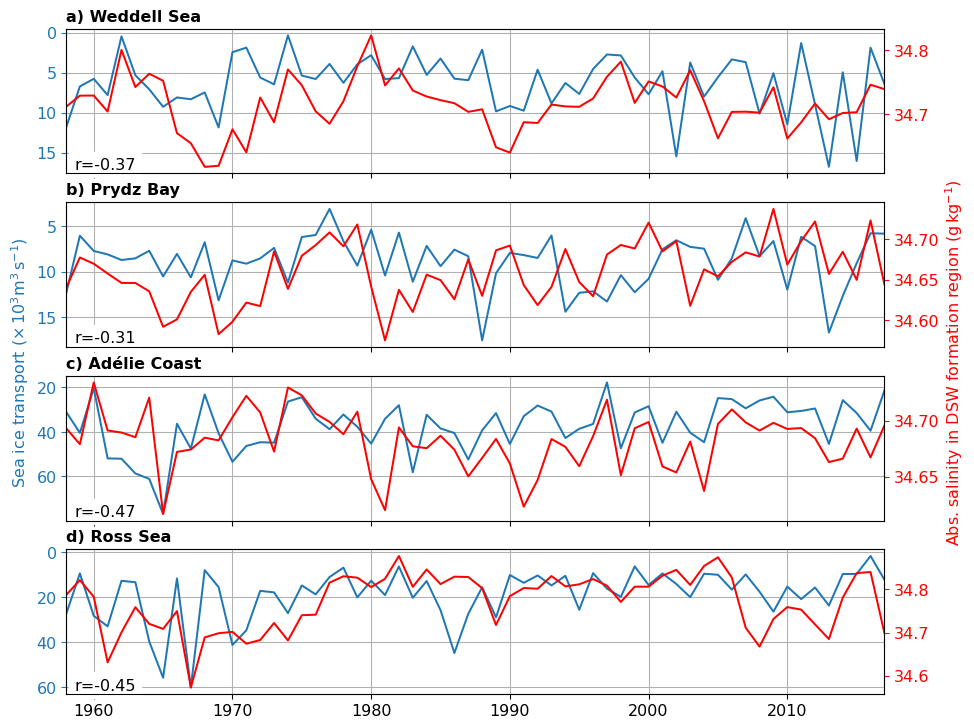

In [56]:
fig = plt.figure(figsize=(11, 9))
plt.subplots_adjust(hspace=0.2)

dsig0 = [0.08, 0.01, -0.05, 0.13]
for a, area_text in enumerate(DSW_region['name']):
    plt.subplot(4, 1, a+1)
    plt.plot(ice_transp.time, 1e-3*ice_transp.sel(area=area_text), color='tab:blue')
    plt.gca().invert_yaxis()
    plt.gca().tick_params(axis='y', colors='tab:blue')
    r, p_val = correlation_3D(
        ice_transp[a, :], salt_DSW[a, :], dims='time')
    plt.title(string.ascii_lowercase[a] + ') ' + DSW_region['name_long'][a],
             fontweight='bold', loc='left')
    plt.text(0.01, 0.03, 'r=' + str(np.round(r.values, 2)),
             backgroundcolor='w', transform=plt.gca().transAxes)
    plt.autoscale(enable=True, axis='x', tight=True)
    if a < 3:
        plt.gca().set_xticklabels([])
    plt.grid(axis='both')

    ax2 = plt.gca().twinx()
    plt.plot(salt_DSW.time, salt_DSW[a, :], label=area_text, color='r')
    ax2.tick_params(axis='y', colors='r')

ax = plt.gcf().add_subplot(111, frameon=False)
ax2 = ax.twinx()
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False,
               right=False)
ax.set_ylabel(r'Sea ice transport ($\times\,$10$^{3}$m$^{3}\,$s$^{-1}$)',
              labelpad=0, color='tab:blue')
ax2.tick_params(labelcolor='none', top=False, bottom=False, left=False,
                right=False)
ax2.set_ylabel('Abs. salinity in DSW formation region (g$\,$kg$^{-1}$)',
               labelpad=18, color='r')
ax2.set_frame_on(False) 

if savefigures is True:
    plt.savefig(path_Plots + 'FigS1.png', dpi=300, bbox_inches="tight")
    plt.savefig(path_Plots + 'FigS1.pdf', dpi=300, bbox_inches="tight")

plt.show()

## Supplementary figure 2

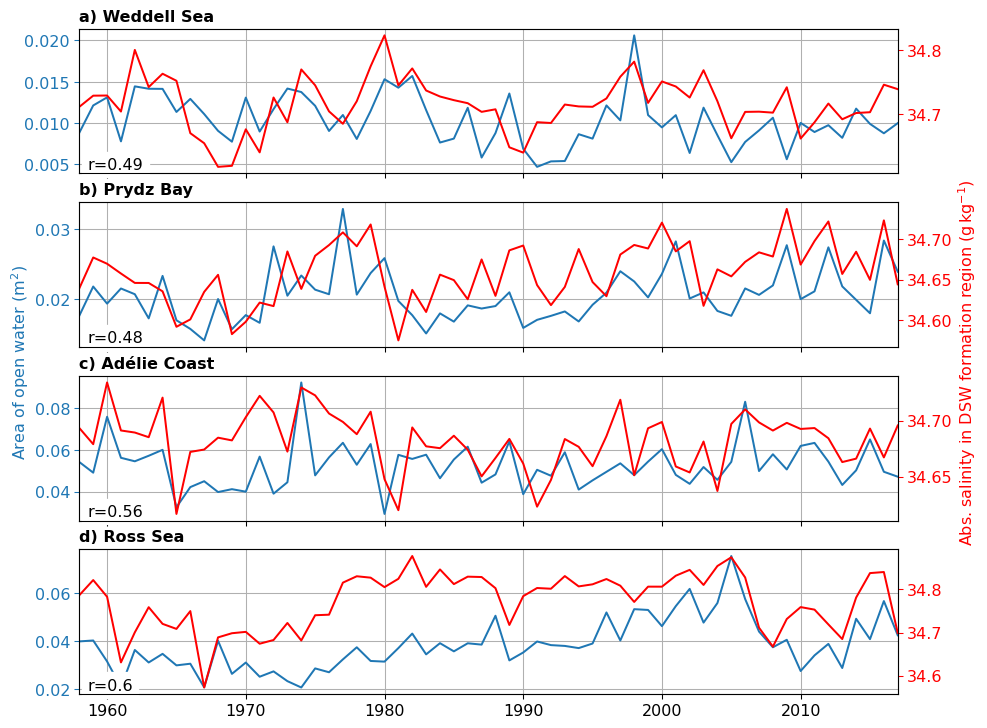

In [57]:
fig = plt.figure(figsize=(11, 9))
plt.subplots_adjust(hspace=0.2)

dsig0 = [0.08, 0.01, -0.05, 0.13]
for a, area_text in enumerate(DSW_region['name']):
    plt.subplot(4, 1, a+1)
    plt.plot(area_open_water.time, area_open_water.sel(area=area_text),
             color='tab:blue')
    plt.gca().tick_params(axis='y', colors='tab:blue')
    r, p_val = correlation_3D(
        area_open_water[a, :], salt_DSW[a, :], dims='time')
    plt.title(string.ascii_lowercase[a] + ') ' + DSW_region['name_long'][a],
             fontweight='bold', loc='left')
    plt.text(0.01, 0.03, 'r=' + str(np.round(r.values, 2)),
             backgroundcolor='w', transform=plt.gca().transAxes)
    plt.autoscale(enable=True, axis='x', tight=True)
    if a < 3:
        plt.gca().set_xticklabels([])
    plt.grid(axis='both')

    ax2 = plt.gca().twinx()
    plt.plot(salt_DSW.time, salt_DSW[a, :], label=area_text, color='r')
    ax2.tick_params(axis='y', colors='r')

\
ax = plt.gcf().add_subplot(111, frameon=False)
ax2 = ax.twinx()
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False,
               right=False)
ax.set_ylabel('Area of open water (m$^{2}$)',
              labelpad=10, color='tab:blue')
ax2.tick_params(labelcolor='none', top=False, bottom=False, left=False,
                right=False)
ax2.set_ylabel('Abs. salinity in DSW formation region (g$\,$kg$^{-1}$)',
               labelpad=18, color='r')
ax2.set_frame_on(False) 

if savefigures is True:
    plt.savefig(path_Plots + 'FigS2.png', dpi=300, bbox_inches="tight")
    plt.savefig(path_Plots + 'FigS2.pdf', dpi=300, bbox_inches="tight")

plt.show()

### Figure 6+7 merged to show Weddell and Adelie

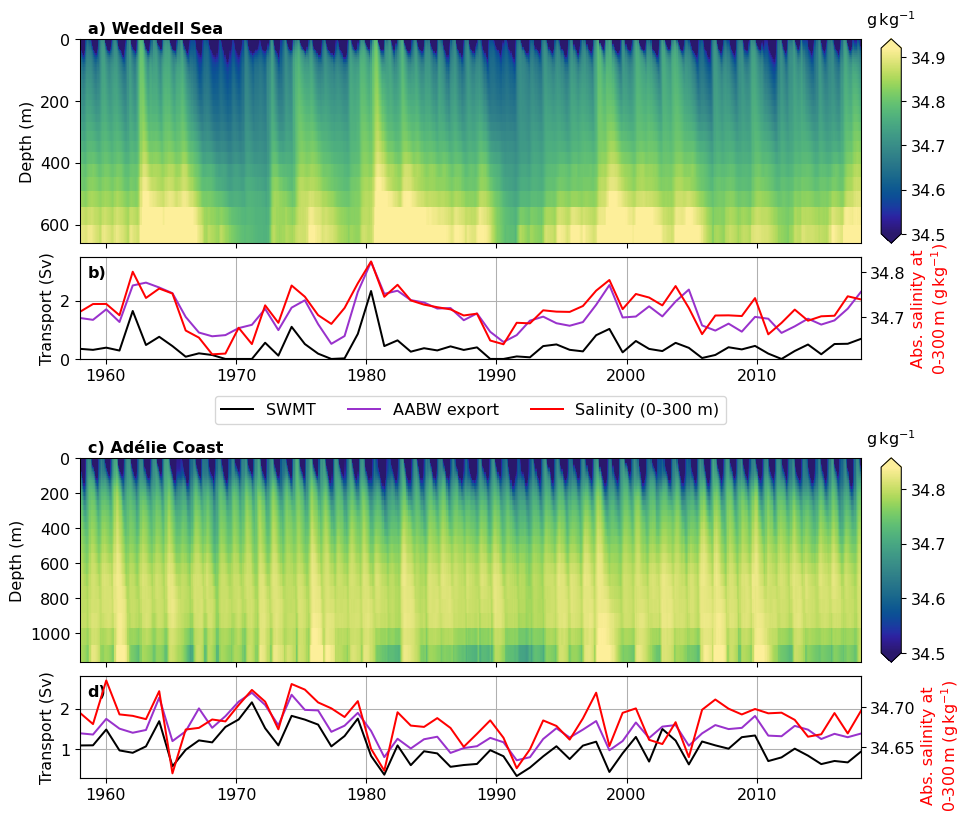

In [58]:
""" Weddell and Adelie"""
fig, ax = plt.subplots(
    figsize=(10.5, 10), nrows=5,
    gridspec_kw={"height_ratios" : [2, 1, .7, 2, 1], "hspace":0.1})
ax[2].axis("off")
v_max = [34.92, 34.82, 34.84, 35.1]

for a in [0, 2]:
    plt.axes(ax[np.int(1.5*a)])
    p = plt.pcolormesh(
        salt_DSW_mean.time.values, salt_DSW_mean.st_ocean,
        salt_DSW_mean[a, :, :].transpose(), cmap=cmo.haline,
        vmin=34.5, vmax=v_max[a], rasterized=True)
    if a == 0:
        plt.ylim(None, 660)
    plt.gca().invert_yaxis()
    plt.ylabel('Depth (m)')
    plt.text(0.01, 1.03, string.ascii_lowercase[a] + ') ' +
             DSW_region['name_long'][a],
             fontweight='bold', transform=plt.gca().transAxes)
    plt.gca().set_xticklabels([])

    padx, pady, width = (0.02, .03, 0.02)
    pos = plt.gca().get_position()
    cax = plt.axes([pos.xmax + padx, pos.ymin, width, (pos.ymax-pos.ymin)])
    plt.colorbar(p, cax=cax, extend='both')
    cax.set_title('g$\,$kg$^{-1}$', pad=10)

    plt.axes(ax[np.int(1.5*a+1)])
    ln1 = plt.plot(SWMT.time+np.linspace(0, 1, 60), SWMT[a, :], 'k', label='SWMT')
    ln2 = plt.plot(AABW_export.time+np.linspace(0, 1, 60), AABW_export[a, :],
                   'darkorchid', label='AABW export')
    plt.ylabel('Transport (Sv)')
    plt.text(0.01, .8, string.ascii_lowercase[a+1] + ')',
              fontweight='bold', transform=plt.gca().transAxes)
    plt.autoscale(enable=True, axis='x', tight=True)
    if a == 0:
        plt.ylim([0, 3.5])
    elif a == 2:
        plt.ylim([.3, 2.8])
    plt.grid(axis='both')
    
    ax2 = plt.gca().twinx()
    ln3 = plt.plot(salt_DSW.time+np.linspace(0, 1, 60), salt_DSW[a, :],
                   'r', label='Salinity (0-300 m)')
    if (a == 1) or (a == 2):
        plt.ylabel('Abs. salinity at\n' + '0-300$\,$m (g$\,$kg$^{-1}$)', color='r', y=0.32)
    else:
        plt.ylabel('Abs. salinity at\n' + '0-300$\,$m (g$\,$kg$^{-1}$)', color='r')
    ax2.autoscale(enable=True, axis='x', tight=True)
    if a < 2:
        lns = ln1+ln2+ln3
        labs = [l.get_label() for l in lns]
        plt.legend(lns, labs, ncol=3, loc='center', bbox_to_anchor=(0.5, -.5))

if savefigures is True:
    plt.savefig(path_Plots + 'Fig6a_7c_combined.png', dpi=300, bbox_inches="tight")
    plt.savefig(path_Plots + 'Fig6a_7c_combined.pdf', dpi=300, bbox_inches="tight")

plt.show()